In [410]:
import sys
import pandas as pd
import os
import numpy as np
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import openmatrix as omx

import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import statsmodels.formula.api as smf

UPDATE_COEFFICIENTS = True

DAMPING_FACTOR = 0.75

ASIM_OUTPUT = r"E:\Met_Council\metc-asim-model\Base_2018\activitysim\output2"
ASIM_CONFIGS_PATH = r'E:\Met_Council\metc-asim-model\source\activitysim\configs'
SURVEY_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\base'
SYNPOP_INPUT = r'E:\Met_Council\metc-asim-model\Input\socioeconomic'
SURVEY_PATH = r'E:\Met_Council\survey_data\Phase2\SPA_Inputs'
SPA_OUTPUT = r'E:\Met_Council\survey_data\Phase2\SPA_Processed'
CENSUS_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\census'
SKIM_PATH = r'E:\Met_Council\metc-asim-model\Base_2018\OMX\allskims.omx'
SKIM_TABLE = 'DIST'

PERTYPEMAP = {1: 'FT', 2: 'PT', 3: 'U', 4: 'NW', 5: 'R', 6: 'SD', 7: 'SPD', 8: 'PS'}
CONFIGS_CODES = {1: 'FULL', 2: 'PART', 3: 'UNIVERSITY', 4: 'NONWORK', 5: 'RETIRED', 6: 'DRIVING', 7: 'SCHOOL', 8: 'PRESCHOOL'}

TOUR_TYPE_TO_PURP = {'work': 'work', 'shopping': 'imain', 'othdiscr': 'idisc', 'othmaint': 'imain', 'school': 'sch', 
    'escort': 'esco', 'eatout': 'idisc', 'social': 'idisc', 'eat': 'idisc', 'maint': 'imain', 'business': 'imain'}

TOUR_TYPES = ['work', 'univ', 'sch', 'esco', 'imain', 'idisc', 'jmain', 'jdisc', 'atwork']

SURVEY_TOUR_PURP = {1: 'work', 2: 'univ', 3: 'sch', 4: 'esco', 5: 'imain', 6: 'imain', 7: 'idisc', 
    8: 'idisc', 9: 'idisc', 10: 'work', 11: 'idisc', 12: 'idisc'}

SAMPLE_RATE = 0.20767

# Read model data
tours = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_tours.csv")).set_index('tour_id')
per = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_persons.csv")).set_index('person_id')

tours['ptype'] = np.array(per['ptype'].reindex(tours['person_id']))
tours['ib_stops'] = tours['stop_frequency'].str[5:6].astype(int)
tours['ob_stops'] = tours['stop_frequency'].str[0:1].astype(int)
tours['purp_coded'] = tours['tour_type'].map(TOUR_TYPE_TO_PURP)
tours.loc[tours['tour_category'] == 'atwork', 'purp_coded'] = 'atwork'
tours.loc[(tours['purp_coded'] == 'imain') & (tours['tour_category'] == 'joint'), 'purp_coded'] = 'jmain'
tours.loc[(tours['purp_coded'] == 'idisc') & (tours['tour_category'] == 'joint'), 'purp_coded'] = 'jdisc'
# tours.loc[(tours['purp_coded'] == 'iesco') & (tours['tour_category'] == 'joint'), 'purp_coded'] = 'jesco'
tours.loc[(tours['purp_coded'] == 'sch') & (tours['ptype'] == 3), 'purp_coded'] = 'univ'

survey_day_weights = pd.read_csv(r'E:\Met_Council\survey_data\Phase2\weights\day_weights.csv')
spa_tours = {}

for d in np.arange(1, 8):
    tour_input = pd.read_csv(os.path.join(SPA_OUTPUT, f"day{d}", "tours.csv"), low_memory=False)
    tour_input['day_id'] = tour_input['HH_ID'] * 10000 + tour_input['PER_ID'] * 100 + d
    spa_tours[d] = tour_input

survey_tours['OUTBOUND_STOPS'] = survey_tours['OUTBOUND_STOPS'].clip(0, 3)
survey_tours['INBOUND_STOPS'] = survey_tours['INBOUND_STOPS'].clip(0, 3)
survey_tours = pd.concat(spa_tours).merge(survey_day_weights[['day_id', 'day_weight']], how = 'left', on = 'day_id')
survey_tours['HH_PER_DAY_TOUR'] = survey_tours['HH_ID'] * 1000000 + survey_tours['PER_ID'] * 10000 + survey_tours['day_id'] * 100 + survey_tours['TOUR_ID']
survey_tours['PAR_HH_PER_DAY_TOUR'] = survey_tours['HH_ID'] * 1000000 + survey_tours['PER_ID'] * 10000 + survey_tours['day_id'] * 100 + survey_tours['PARENT_TOUR_ID']
survey_tour_purps = survey_tours[['HH_PER_DAY_TOUR', 'TOURPURP']].copy().set_index('HH_PER_DAY_TOUR')
survey_tours['day_weight'].fillna(0, inplace = True)
survey_tours['purp_coded'] = survey_tours['TOURPURP'].map(SURVEY_TOUR_PURP)
survey_tours.loc[(survey_tours['FULLY_JOINT'] == 1) & (survey_tours['purp_coded'] == 'imain'), 'purp_coded'] = 'jmain'
survey_tours.loc[(survey_tours['FULLY_JOINT'] == 1) & (survey_tours['purp_coded'] == 'idisc'), 'purp_coded'] = 'jdisc'
# survey_tours.loc[(survey_tours['FULLY_JOINT'] == 1) & (survey_tours['purp_coded'] == 'iesco'), 'purp_coded'] = 'jesco'
survey_tours['parent_purp'] = np.array(survey_tour_purps['TOURPURP'].reindex(survey_tours['PAR_HH_PER_DAY_TOUR']))
survey_tours.loc[(survey_tours['IS_SUBTOUR'] == 1) & (survey_tours['parent_purp'].isin([1, 10])), 'purp_coded'] = 'atwork'

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\2075765992.py:46: DtypeWarning: Columns (16,28) have mixed types. Specify dtype option on import or set low_memory=False.
  tours = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_tours.csv")).set_index('tour_id')


In [411]:
survey_ob_stops = survey_tours.rename(columns = {'PERSONTYPE': 'ptype', 'OUTBOUND_STOPS': 'ob_stops'}).groupby(['ptype', 'ob_stops', 'purp_coded']).agg(survey = ('day_weight', 'sum'))
survey_ib_stops = survey_tours.rename(columns = {'PERSONTYPE': 'ptype', 'INBOUND_STOPS': 'ib_stops'}).groupby(['ptype', 'ib_stops', 'purp_coded']).agg(survey = ('day_weight', 'sum'))

survey_ob_tot_stops = survey_tours.rename(columns = {'PERSONTYPE': 'ptype', 'OUTBOUND_STOPS': 'ob_stops'}).groupby(['ptype', 'ob_stops']).agg(survey = ('day_weight', 'sum'))
survey_ib_tot_stops = survey_tours.rename(columns = {'PERSONTYPE': 'ptype', 'INBOUND_STOPS': 'ib_stops'}).groupby(['ptype', 'ib_stops']).agg(survey = ('day_weight', 'sum'))

survey_ob_stops_purp = survey_tours.rename(columns = {'PERSONTYPE': 'ptype', 'OUTBOUND_STOPS': 'ob_stops'}).groupby(['purp_coded', 'ob_stops']).agg(survey = ('day_weight', 'sum'))
survey_ib_stops_purp = survey_tours.rename(columns = {'PERSONTYPE': 'ptype', 'INBOUND_STOPS': 'ib_stops'}).groupby(['purp_coded', 'ib_stops']).agg(survey = ('day_weight', 'sum'))

survey_combined_purp = survey_tours.rename(columns = {'PERSONTYPE': 'ptype', 'INBOUND_STOPS': 'ib_stops', 'OUTBOUND_STOPS': 'ob_stops'}).groupby(['purp_coded', 'ob_stops', 'ib_stops']).agg(survey = ('day_weight', 'sum'))

In [412]:
model_sum_ib = tours.groupby(['ptype', 'ib_stops', 'purp_coded']).agg(model = ('household_id', 'count')) / SAMPLE_RATE
model_sum_ob = tours.groupby(['ptype','ob_stops', 'purp_coded']).agg(model = ('household_id', 'count')) / SAMPLE_RATE

model_sum_ib_tot = tours.groupby(['ptype', 'ib_stops']).agg(model = ('household_id', 'count')) / SAMPLE_RATE
model_sum_ob_tot = tours.groupby(['ptype', 'ob_stops']).agg(model = ('household_id', 'count')) / SAMPLE_RATE

model_sum_ib_purp = tours.groupby(['purp_coded', 'ib_stops']).agg(model = ('household_id', 'count')) / SAMPLE_RATE
model_sum_ob_purp = tours.groupby(['purp_coded','ob_stops']).agg(model = ('household_id', 'count')) / SAMPLE_RATE

model_combined_purp = tours.groupby(['purp_coded', 'ob_stops', 'ib_stops']).agg(model = ('household_id', 'count')) / SAMPLE_RATE

In [413]:
ob_compare = model_sum_ob.join(survey_ob_stops)
ib_compare = model_sum_ib.join(survey_ib_stops)

ob_tot_com = model_sum_ob_tot.join(survey_ob_tot_stops)
ib_tot_com = model_sum_ib_tot.join(survey_ib_tot_stops)

ob_purp = model_sum_ob_purp.join(survey_ob_stops_purp)
ib_purp = model_sum_ib_purp.join(survey_ib_stops_purp)

comb_purp = survey_combined_purp.join(model_combined_purp)

# Plots

## Summarized

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\3098185050.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\3098185050.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\3098185050.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\3098185050.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is

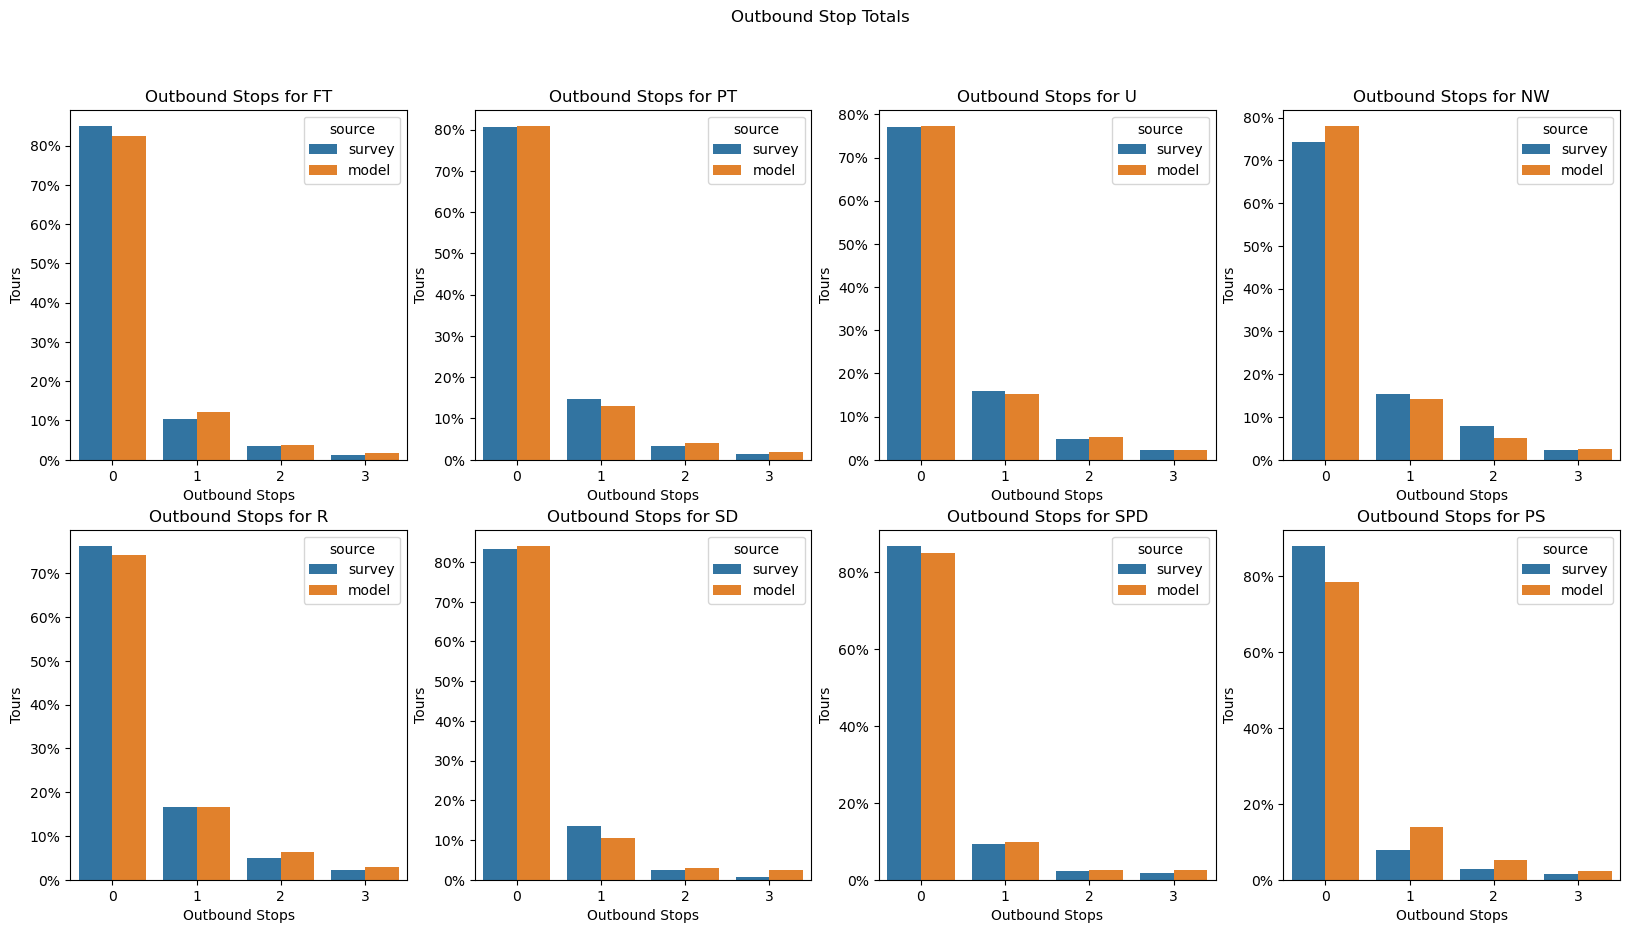

In [414]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize=(20, 10))
plot_idx = 240
count = 1
for pt_key, pt_val in PERTYPEMAP.items():
    plot_data1 = ob_tot_com.xs(pt_key, level = 0).reset_index()
    plot_data1['model'] = plot_data1['model'] / plot_data1['model'].sum()
    plot_data1['survey'] = plot_data1['survey'] / plot_data1['survey'].sum()
    plot_data1 = plot_data1.melt(id_vars = ['ob_stops'], var_name = 'source', value_name = 'tours')
    plot_data = pd.concat([plot_data1[plot_data1['source'] == 'survey'], plot_data1[plot_data1['source'] == 'model']])
    ax = plt.subplot(plot_idx + count)
    sns.barplot(data = plot_data, x = 'ob_stops', y = 'tours', hue = 'source')
    plt.title(f"Outbound Stops for {pt_val}")
    plt.ylabel('Tours')
    plt.xlabel('Outbound Stops')
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0%}'))
    count += 1
plt.suptitle(f"Outbound Stop Totals")
plt.show()

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\3242805600.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\3242805600.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\3242805600.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\3242805600.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is

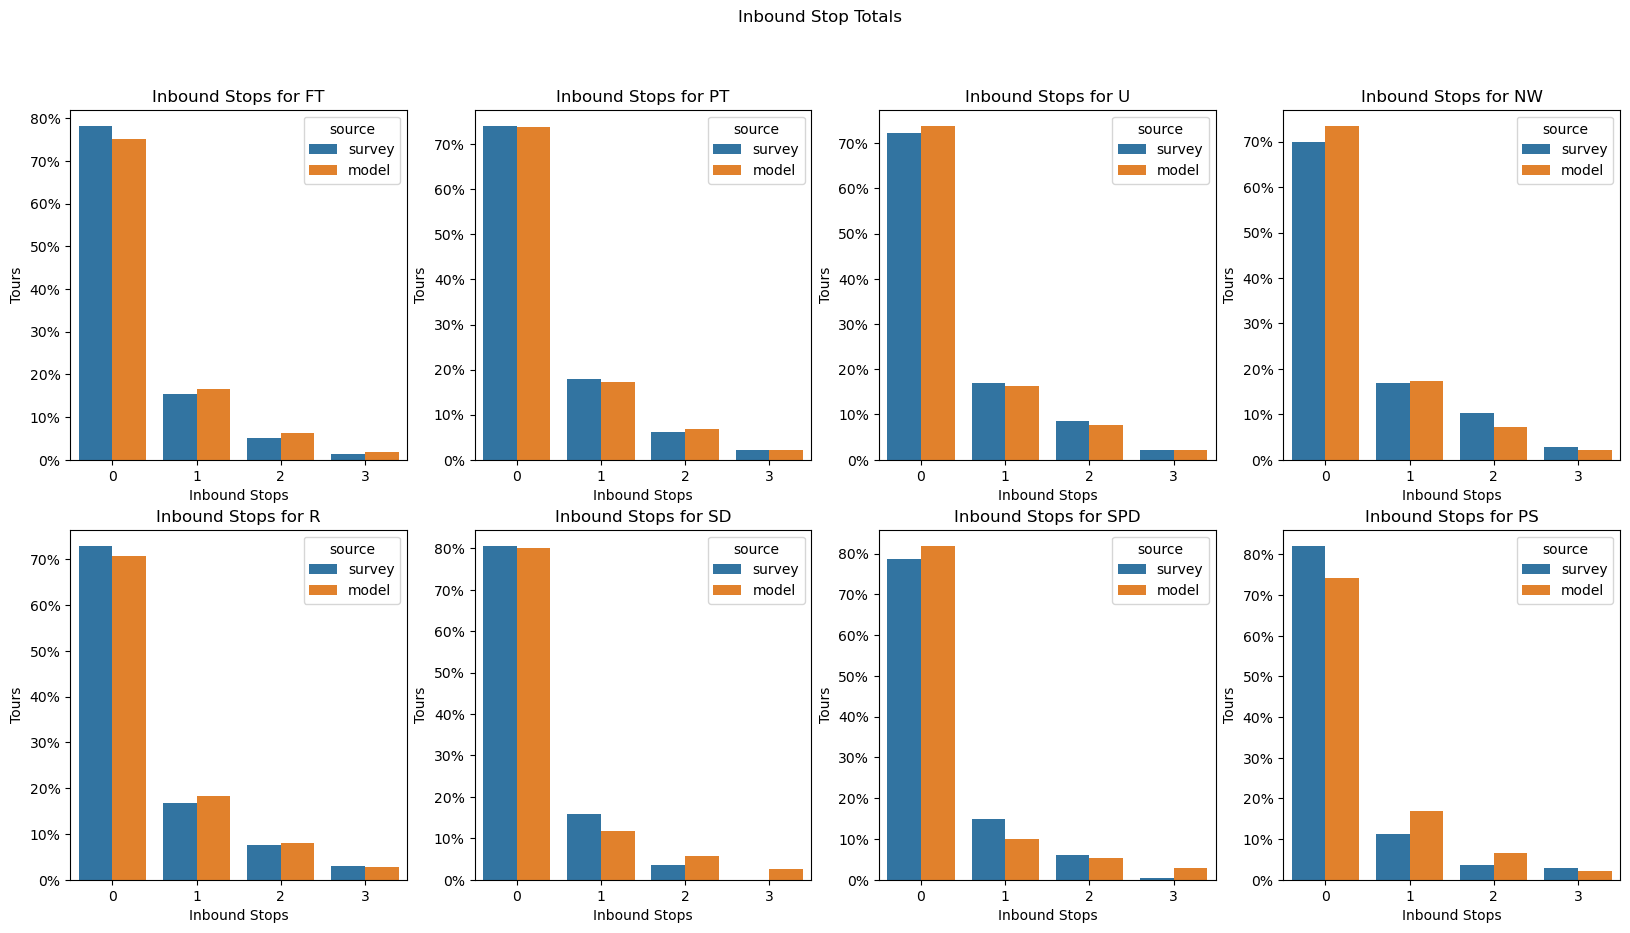

In [415]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize=(20, 10))
plot_idx = 240
count = 1
for pt_key, pt_val in PERTYPEMAP.items():
    plot_data1 = ib_tot_com.xs(pt_key, level = 0).reset_index()
    plot_data1['model'] = plot_data1['model'] / plot_data1['model'].sum()
    plot_data1['survey'] = plot_data1['survey'] / plot_data1['survey'].sum()
    plot_data1 = plot_data1.melt(id_vars = ['ib_stops'], var_name = 'source', value_name = 'tours')
    plot_data = pd.concat([plot_data1[plot_data1['source'] == 'survey'], plot_data1[plot_data1['source'] == 'model']])
    ax = plt.subplot(plot_idx + count)
    sns.barplot(data = plot_data, x = 'ib_stops', y = 'tours', hue = 'source')
    plt.title(f"Inbound Stops for {pt_val}")
    plt.ylabel('Tours')
    plt.xlabel('Inbound Stops')
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0%}'))
    count += 1
plt.suptitle(f"Inbound Stop Totals")
plt.show()

## For Calibration

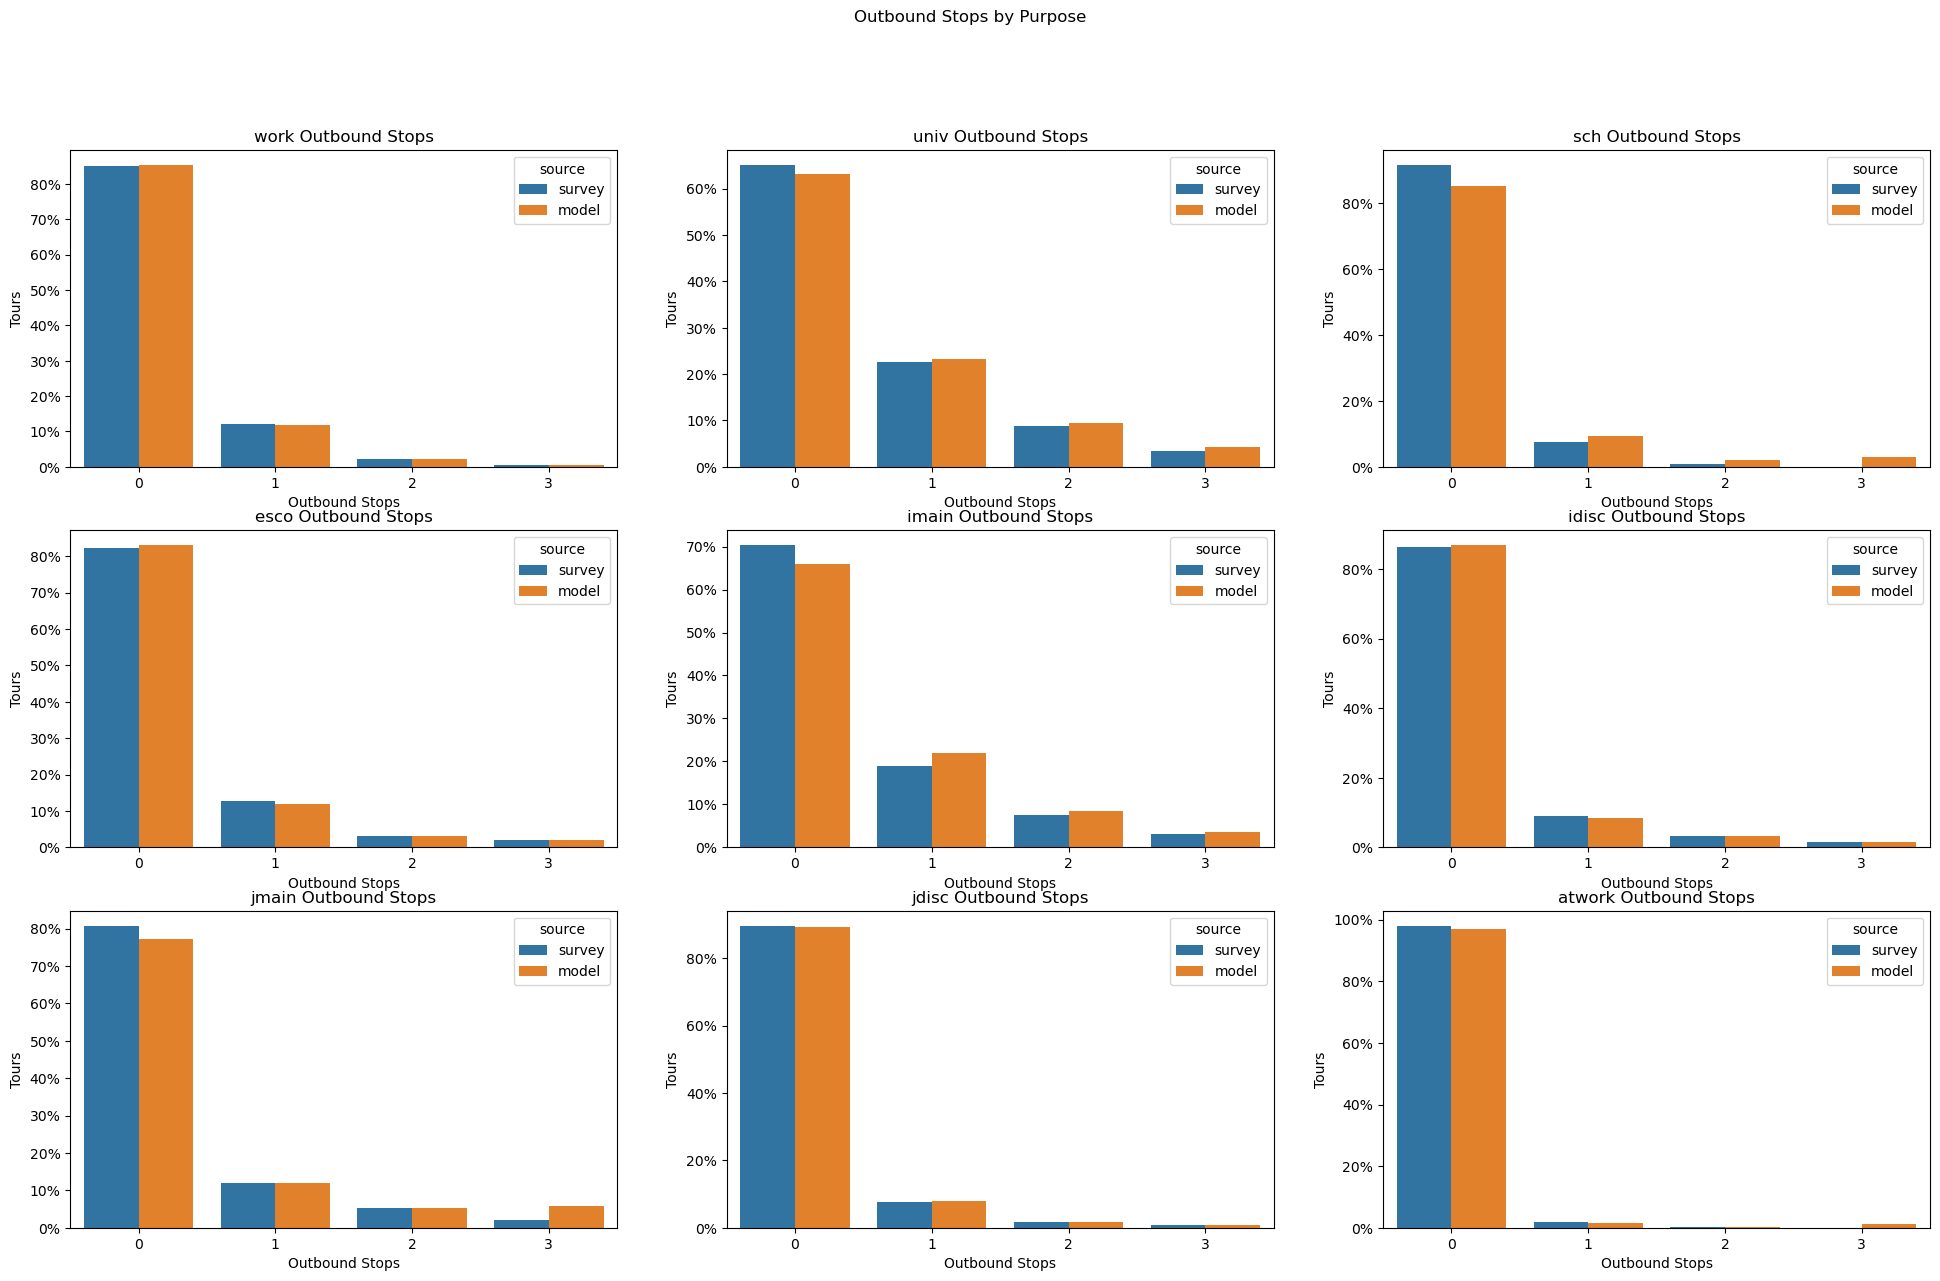

In [416]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(24, 14))
plot_idx = 330
count = 1
for purp in TOUR_TYPES:
    plot_data1 = ob_purp.xs(purp, level = 0).reset_index()
    plot_data1['model'] = plot_data1['model'] / plot_data1['model'].sum()
    plot_data1['survey'] = plot_data1['survey'] / plot_data1['survey'].sum()
    plot_data1 = plot_data1.melt(id_vars = ['ob_stops'], var_name = 'source', value_name = 'tours')    
    plot_data = pd.concat([plot_data1[plot_data1['source'] == 'survey'], plot_data1[plot_data1['source'] == 'model']])
    ax = plt.subplot(plot_idx + count)
    sns.barplot(data = plot_data, x = 'ob_stops', y = 'tours', hue = 'source')
    plt.title(f"{purp} Outbound Stops")
    plt.ylabel('Tours')
    plt.xlabel('Outbound Stops')
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0%}'))
    count += 1
plt.suptitle(f"Outbound Stops by Purpose")
plt.show()

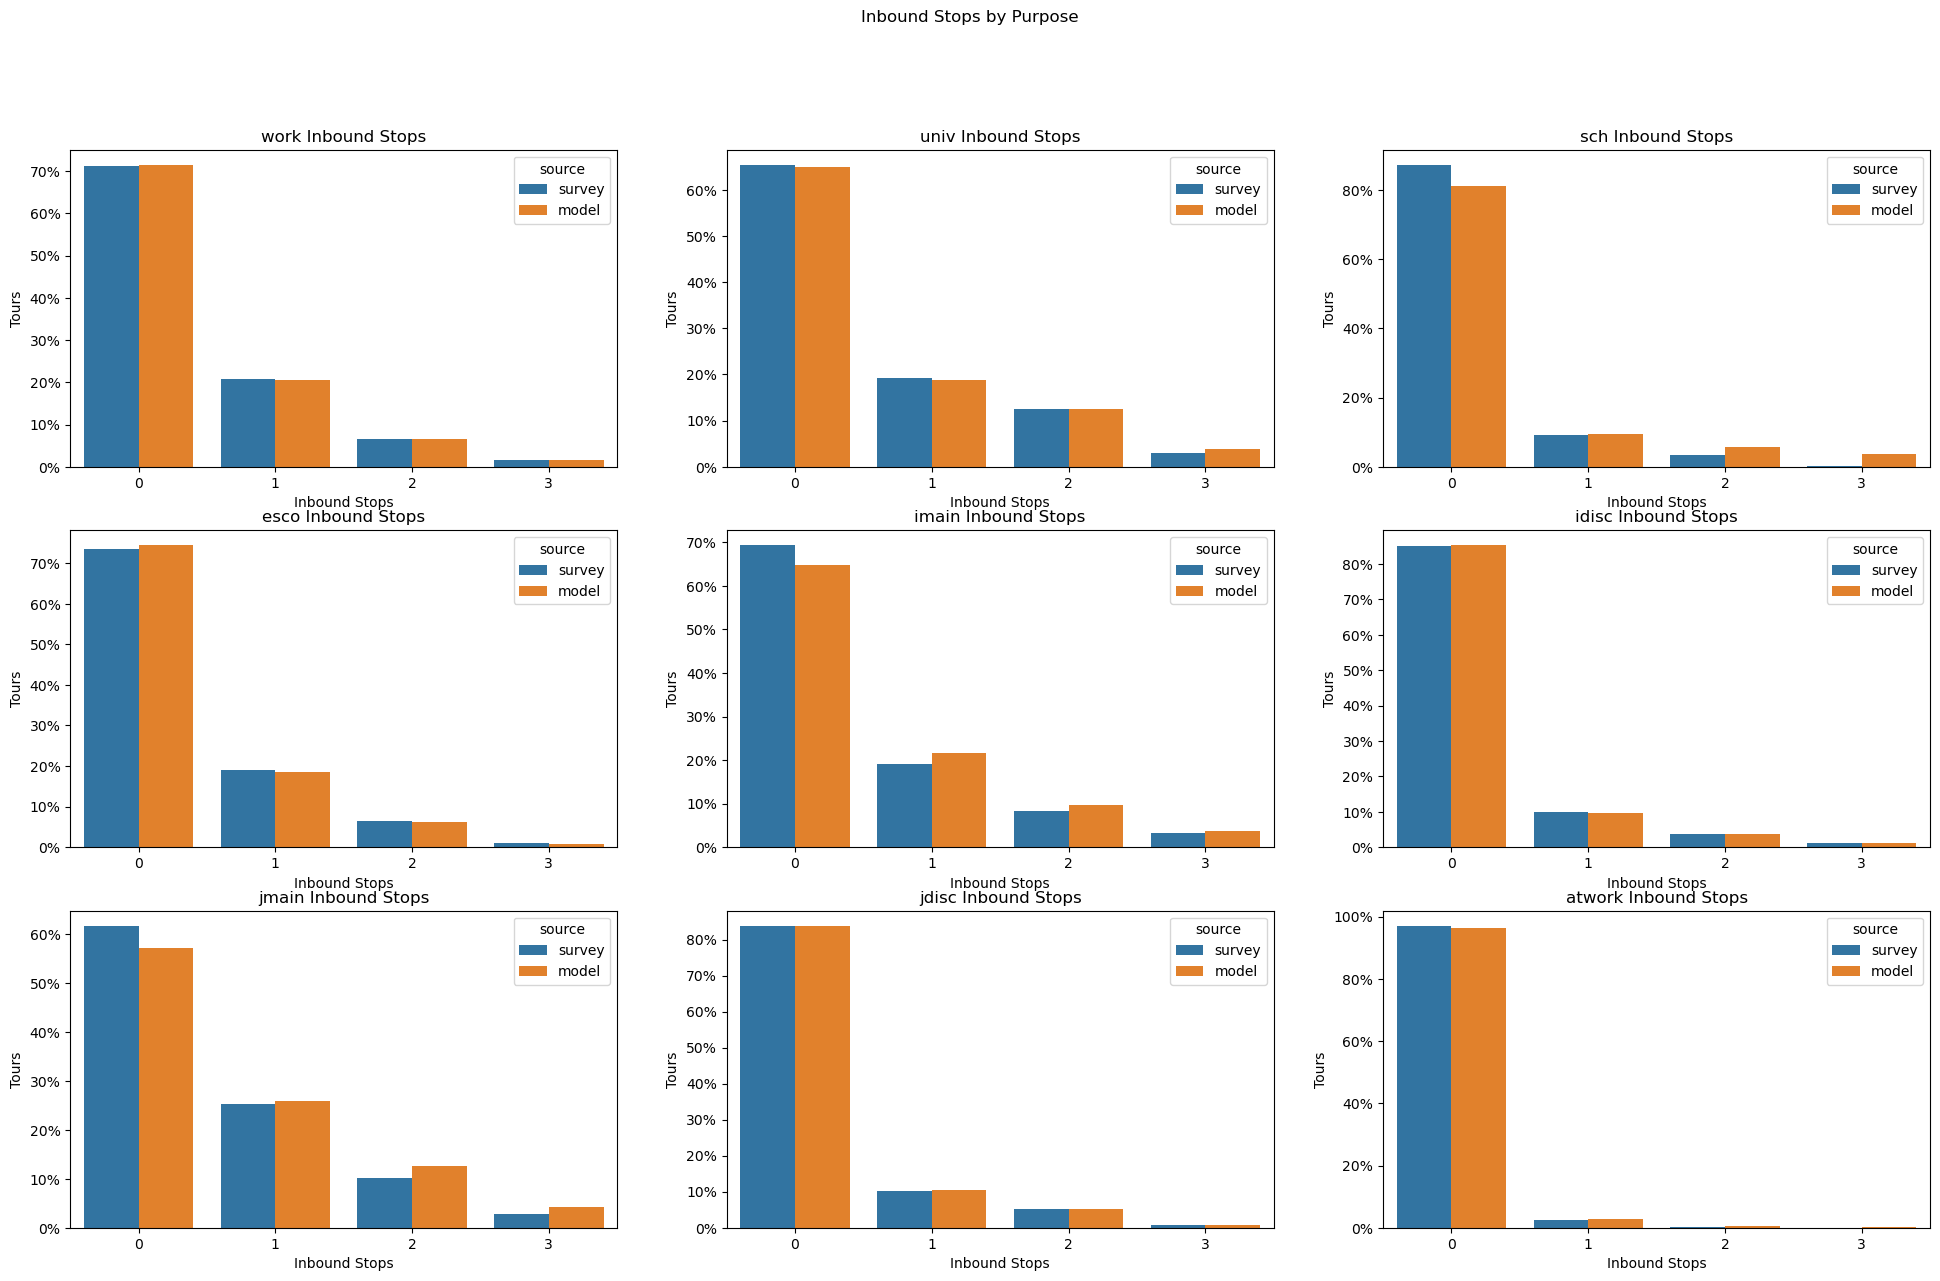

In [417]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(24, 14))
plot_idx = 330
count = 1
for purp in TOUR_TYPES:
    plot_data1 = ib_purp.xs(purp, level = 0).reset_index()
    plot_data1['model'] = plot_data1['model'] / plot_data1['model'].sum()
    plot_data1['survey'] = plot_data1['survey'] / plot_data1['survey'].sum()
    plot_data1 = plot_data1.melt(id_vars = ['ib_stops'], var_name = 'source', value_name = 'tours')    
    plot_data = pd.concat([plot_data1[plot_data1['source'] == 'survey'], plot_data1[plot_data1['source'] == 'model']])
    ax = plt.subplot(plot_idx + count)
    sns.barplot(data = plot_data, x = 'ib_stops', y = 'tours', hue = 'source')
    plt.title(f"{purp} Inbound Stops")
    plt.ylabel('Tours')
    plt.xlabel('Inbound Stops')
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0%}'))
    count += 1
plt.suptitle(f"Inbound Stops by Purpose")
plt.show()

## Detailed

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is dep

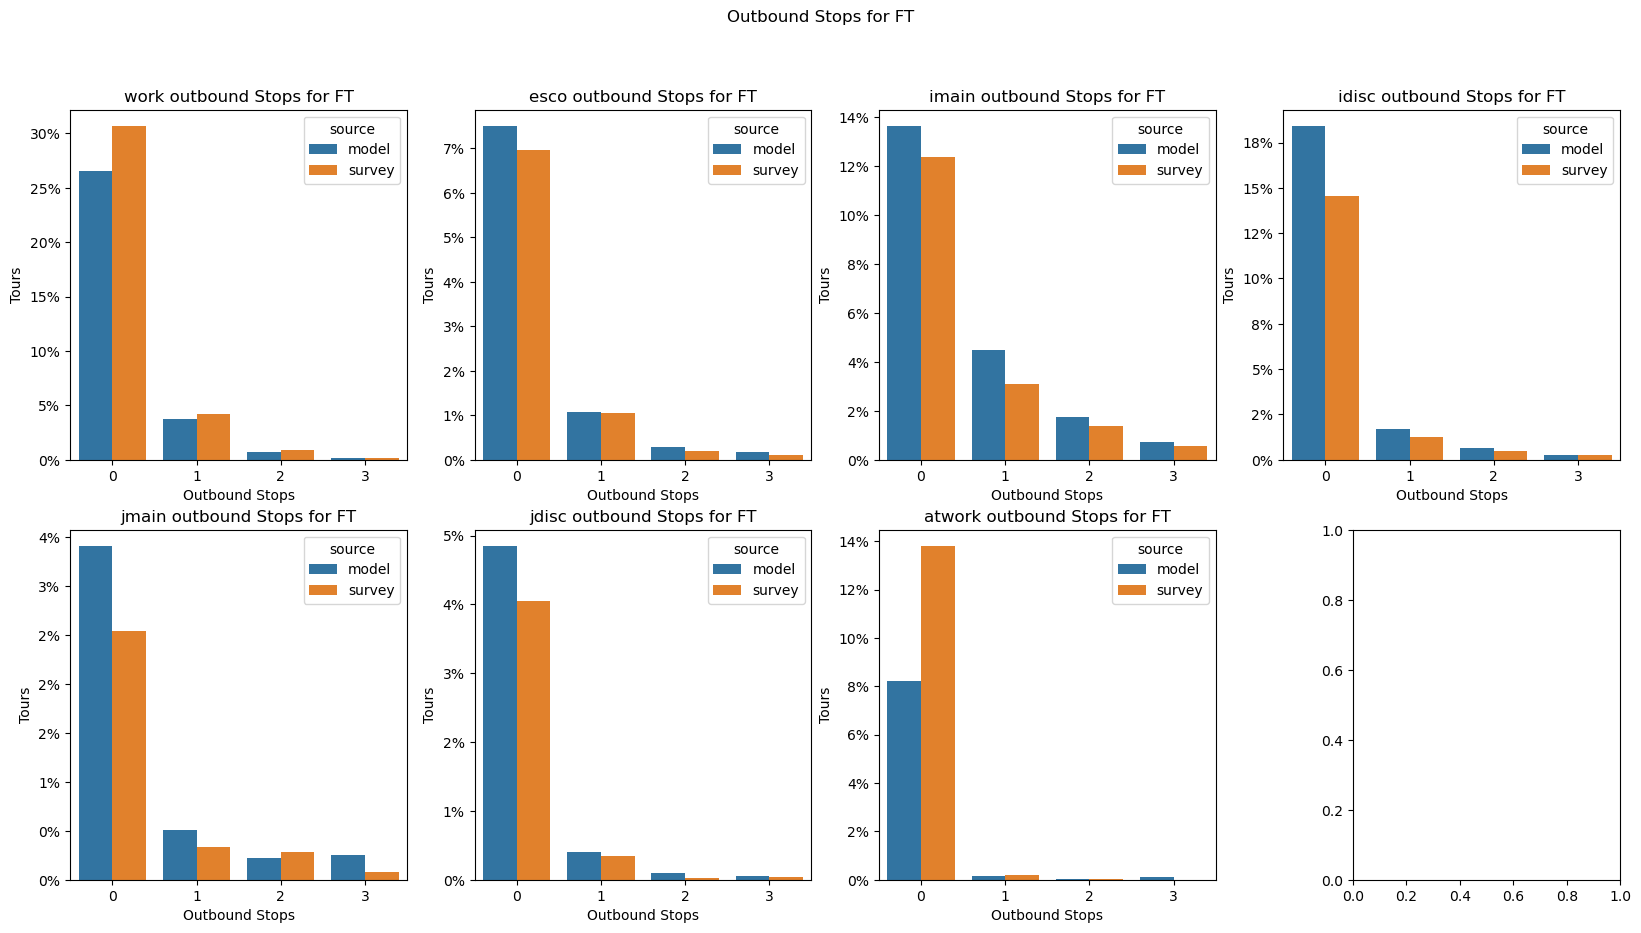

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is dep

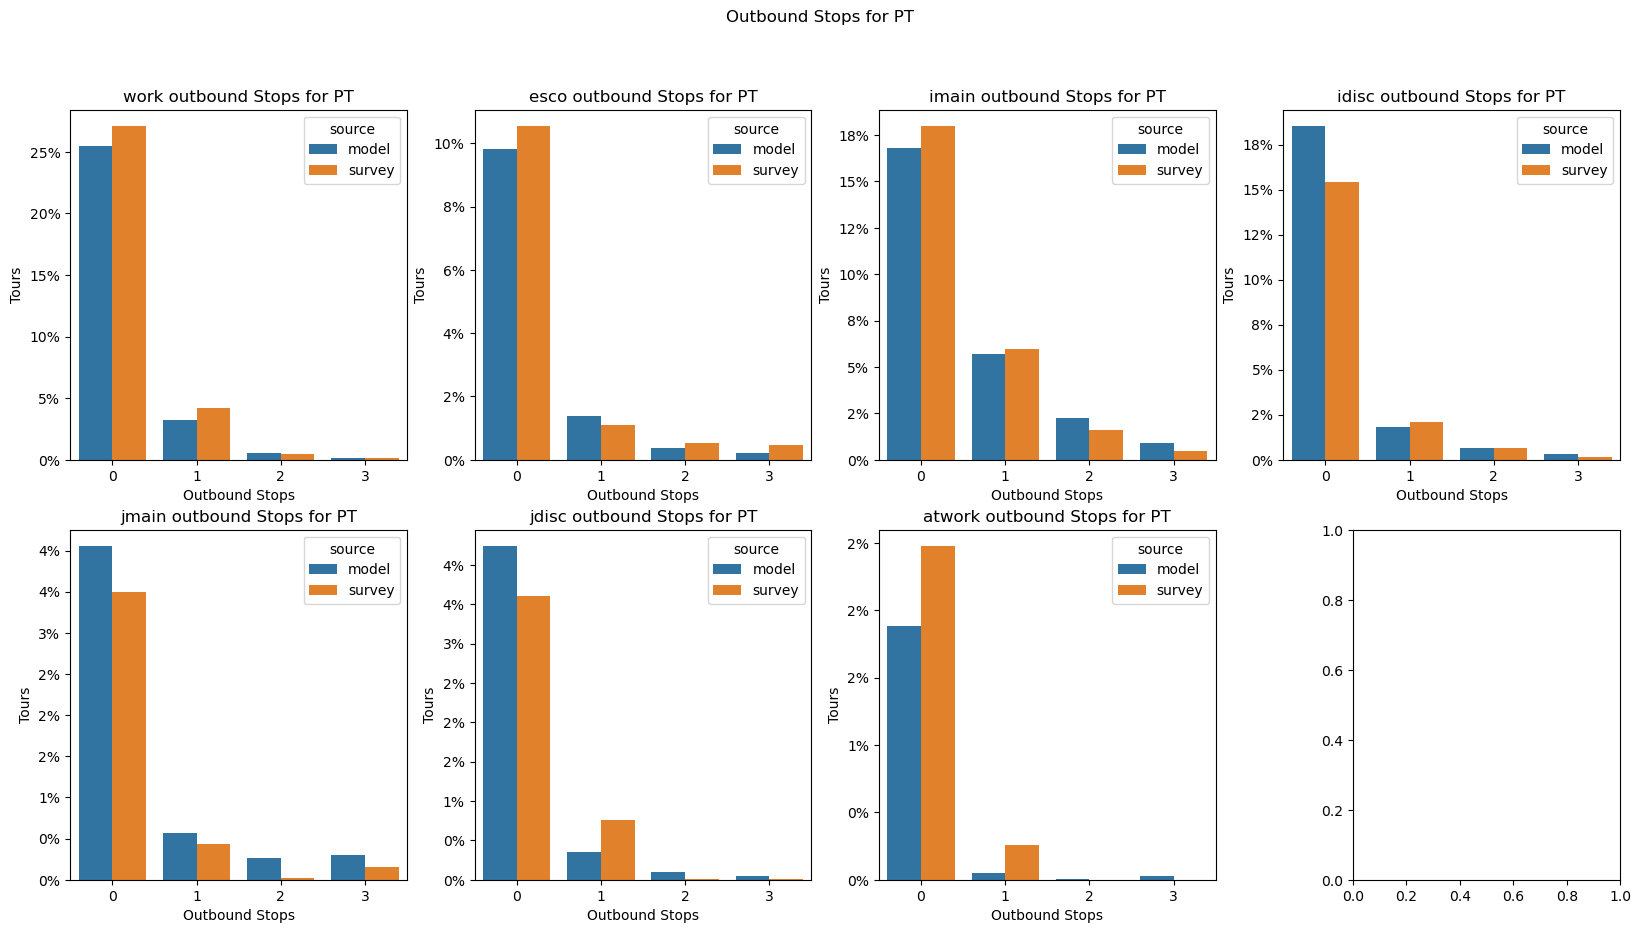

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is dep

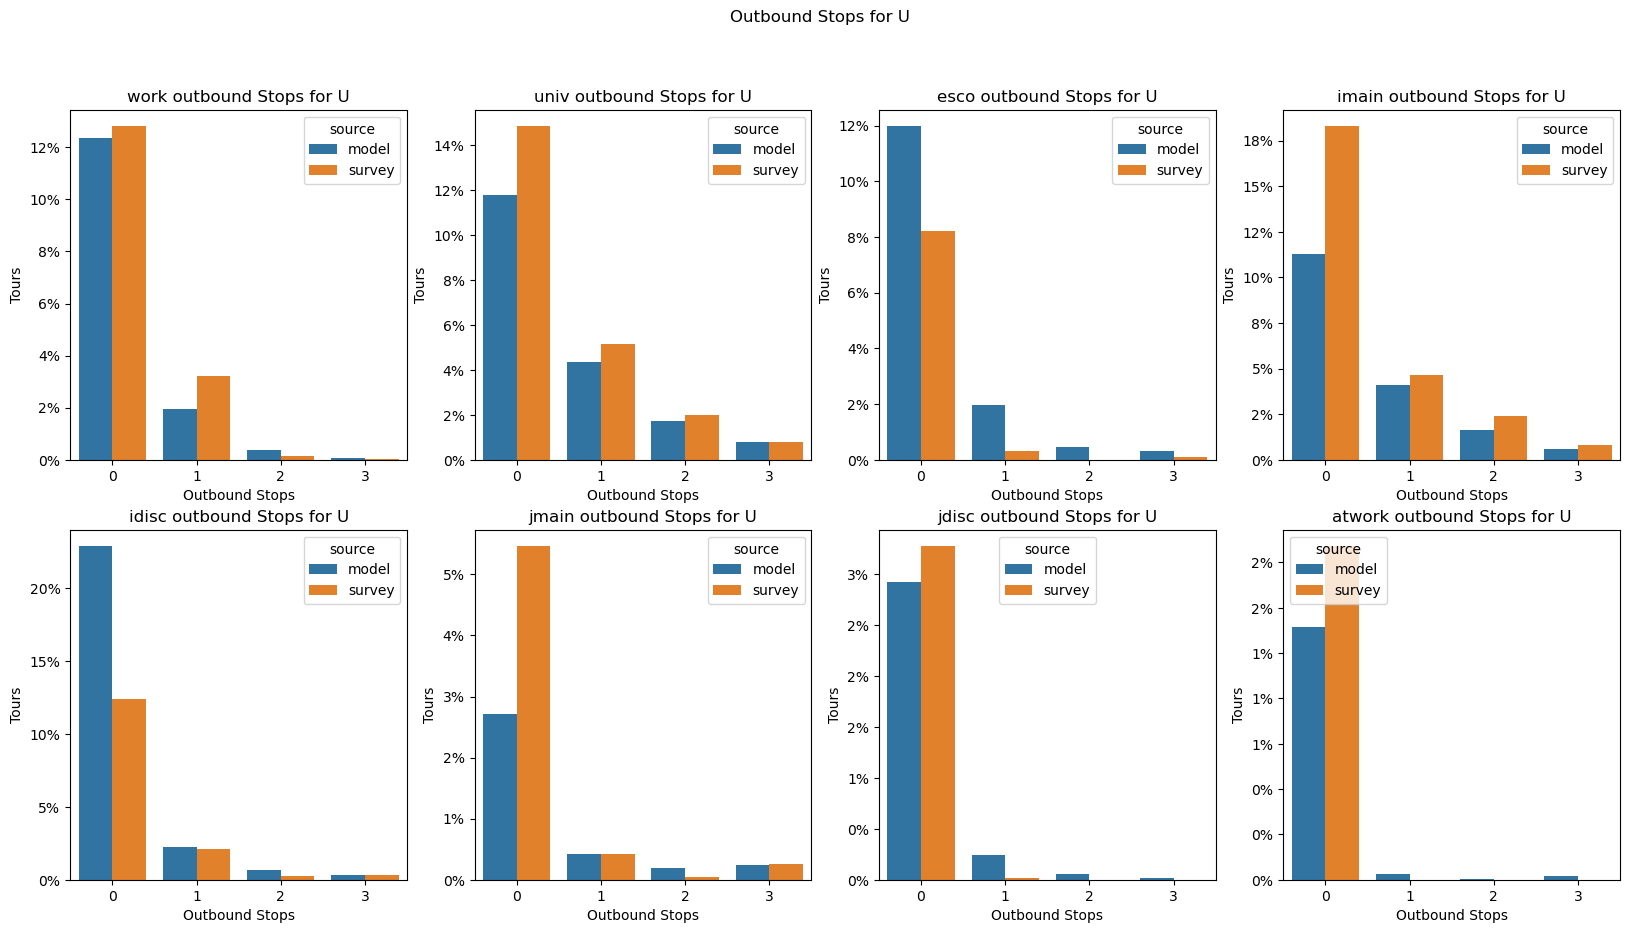

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is dep

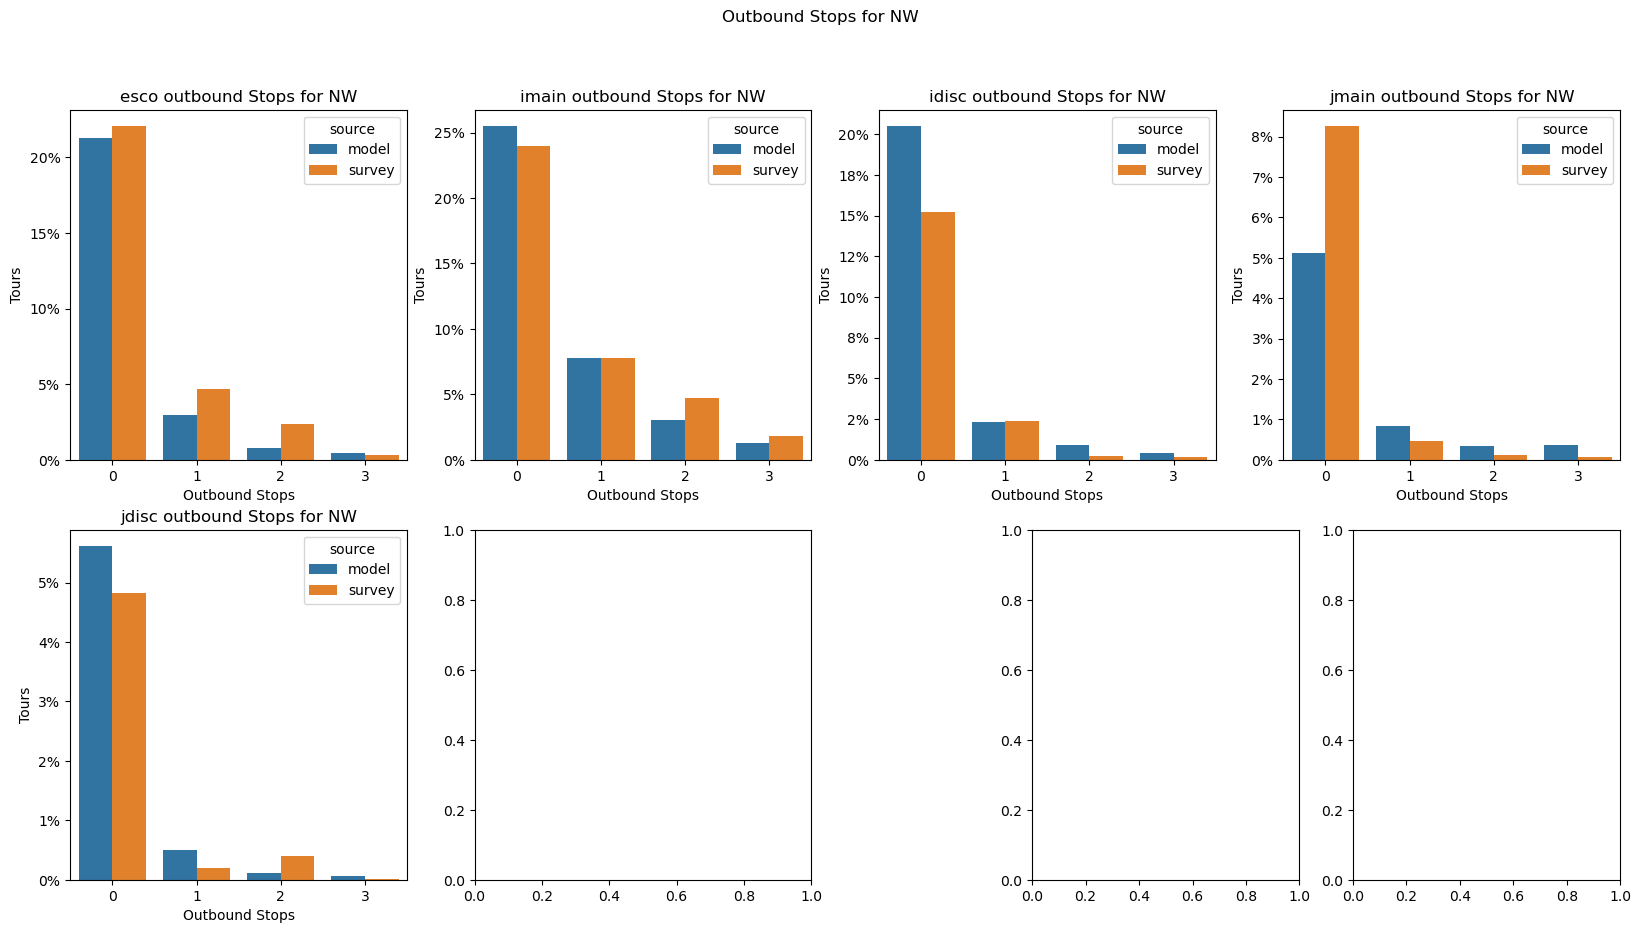

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is dep

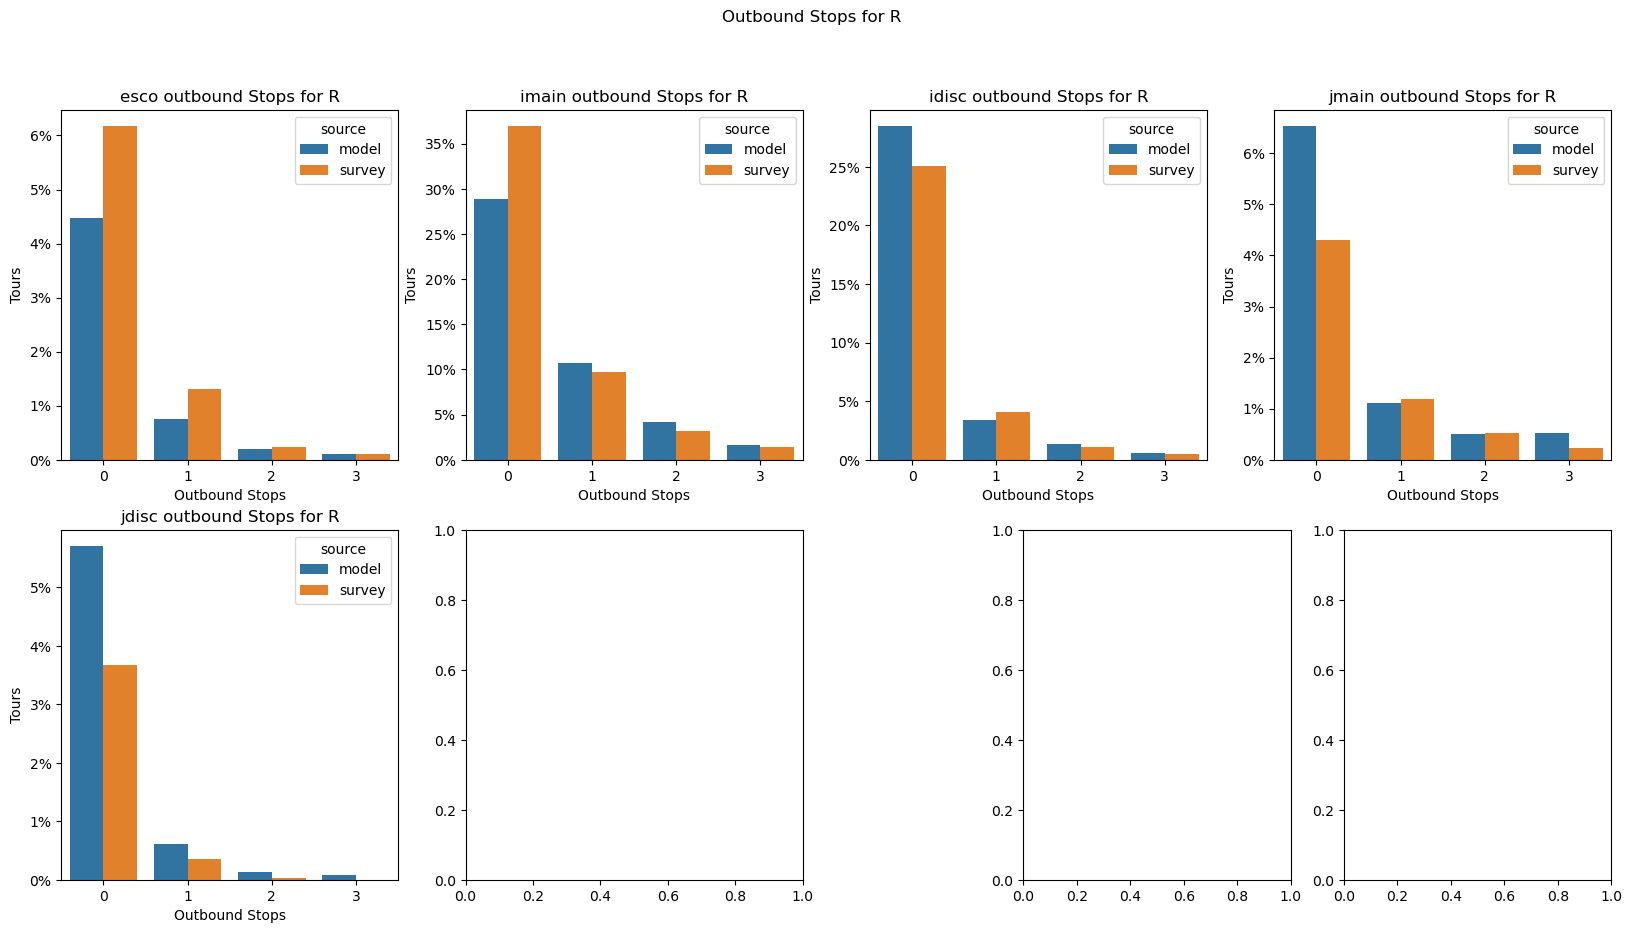

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is dep

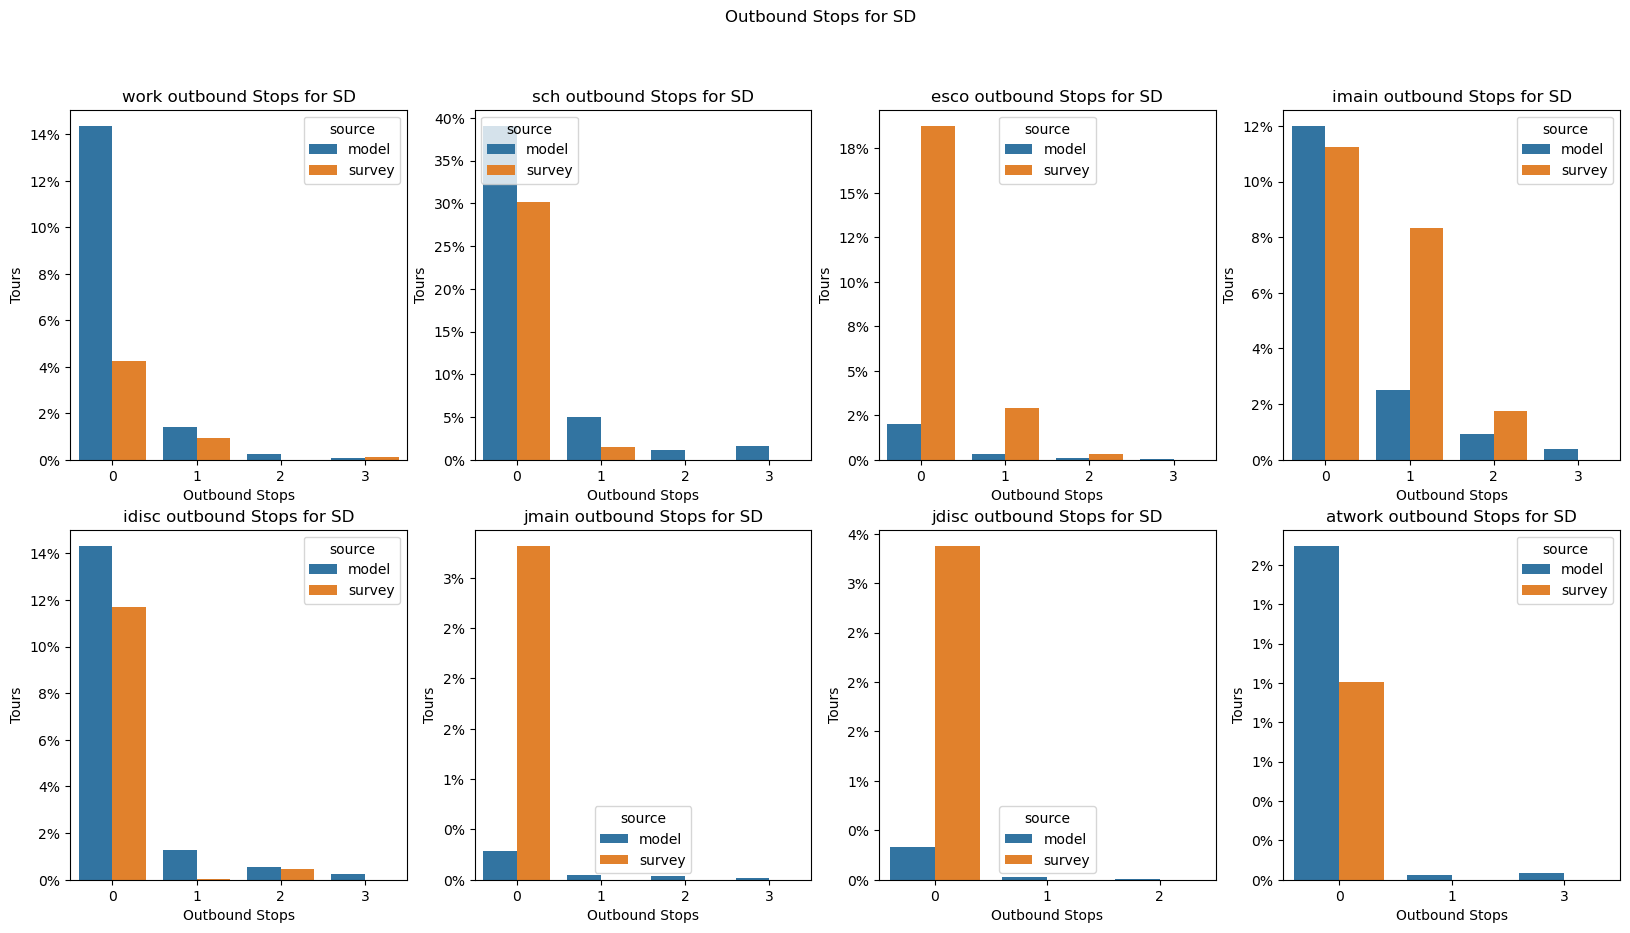

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is dep

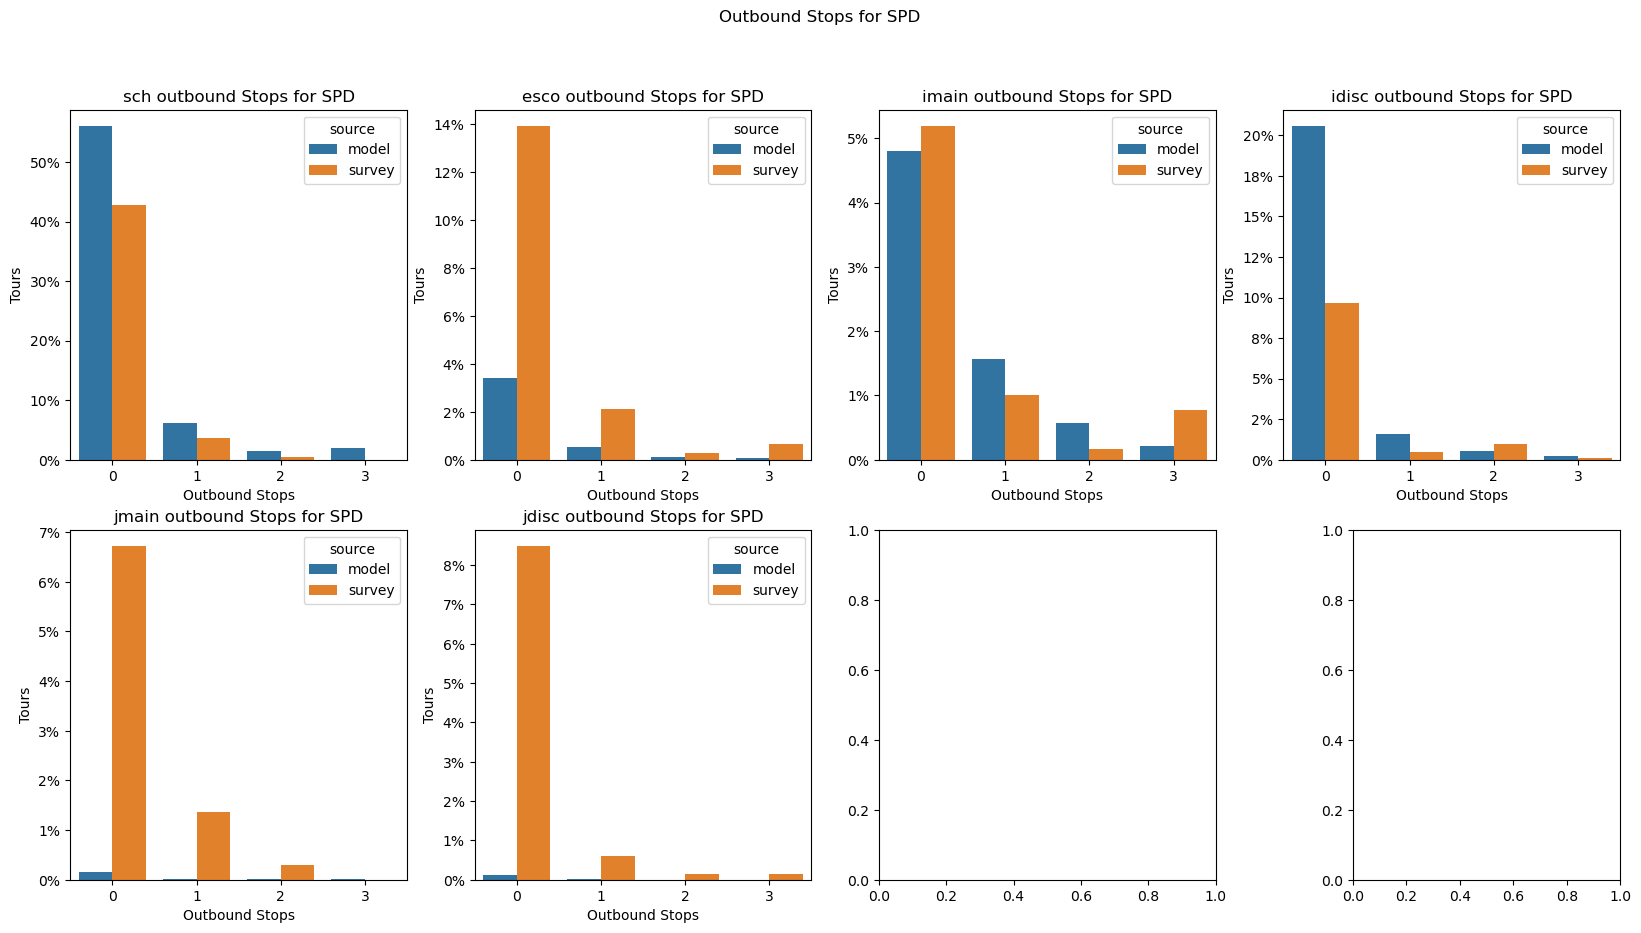

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\706829295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is dep

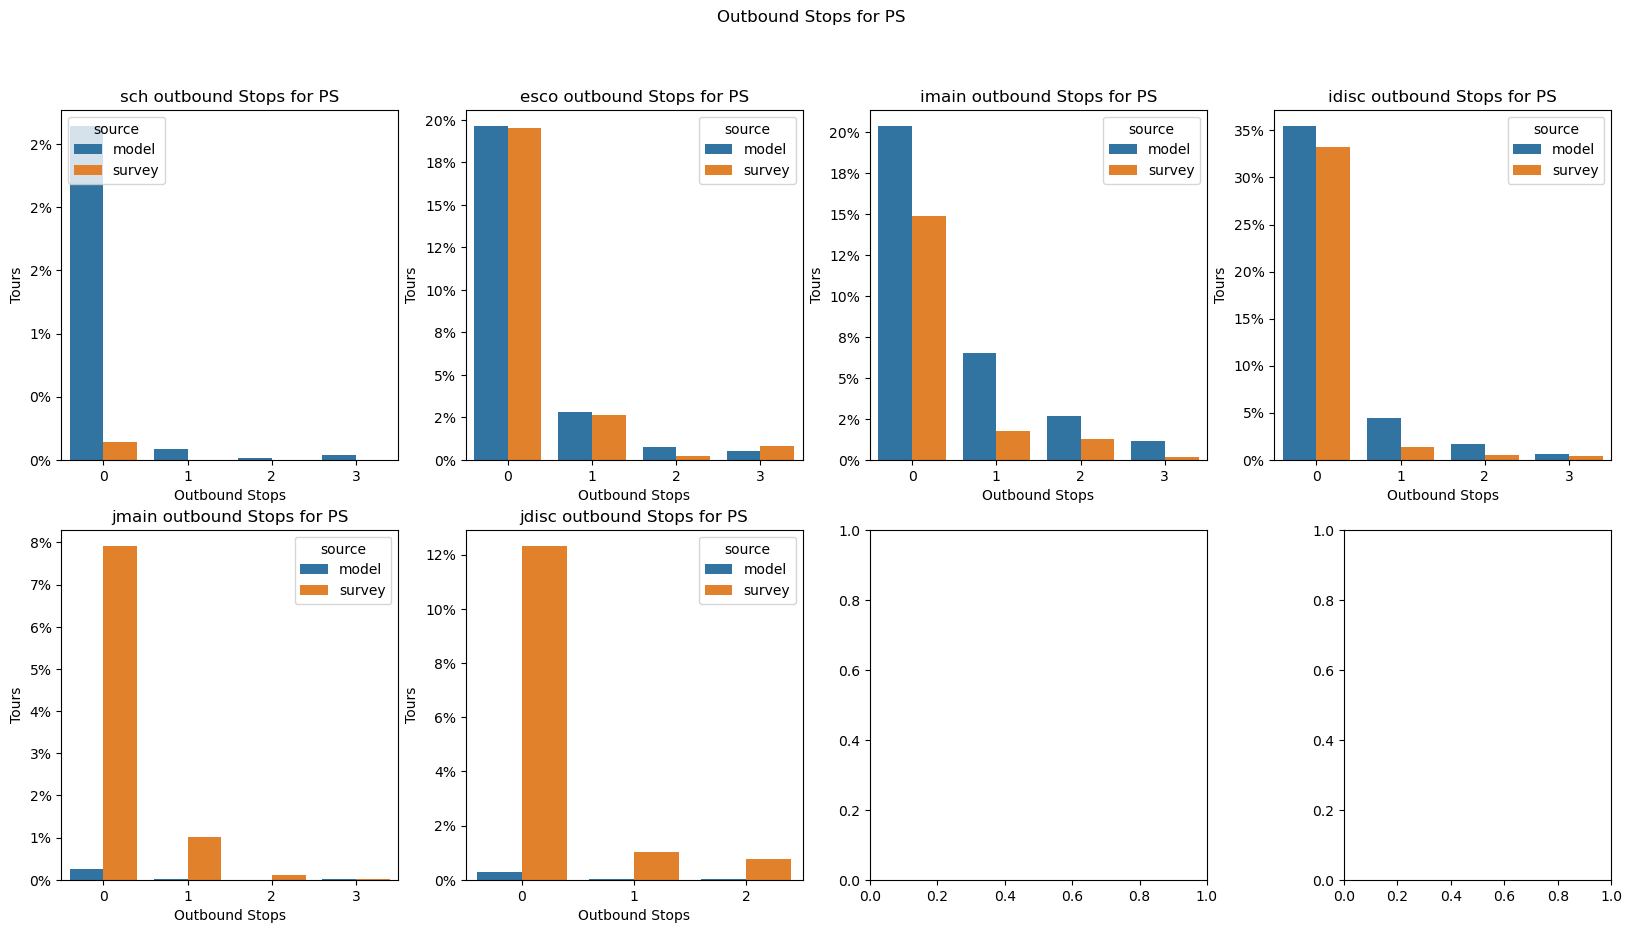

In [418]:
for pt_key, pt_val in PERTYPEMAP.items():
    plot_data1 = ob_compare.xs(pt_key, level = 0).reset_index()
    plot_data1['model'] = plot_data1['model'] / plot_data1['model'].sum()
    plot_data1['survey'] = plot_data1['survey'] / plot_data1['survey'].sum()
    plot_data1 = plot_data1.melt(id_vars = ['ob_stops', 'purp_coded'], var_name = 'source', value_name = 'tours')
    fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize=(20, 10))
    plot_idx = 240
    count = 1
    for purp in TOUR_TYPES:
        plot_data = plot_data1[plot_data1['purp_coded'] == purp]
        ax = plt.subplot(plot_idx + count)
        if plot_data.shape[0] > 0:
            sns.barplot(data = plot_data, x = 'ob_stops', y = 'tours', hue = 'source')
            plt.title(f"{purp} outbound Stops for {pt_val}")
            plt.ylabel('Tours')
            plt.xlabel('Outbound Stops')
            ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0%}'))
            count += 1
    plt.suptitle(f"Outbound Stops for {pt_val}")
    plt.show()

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is

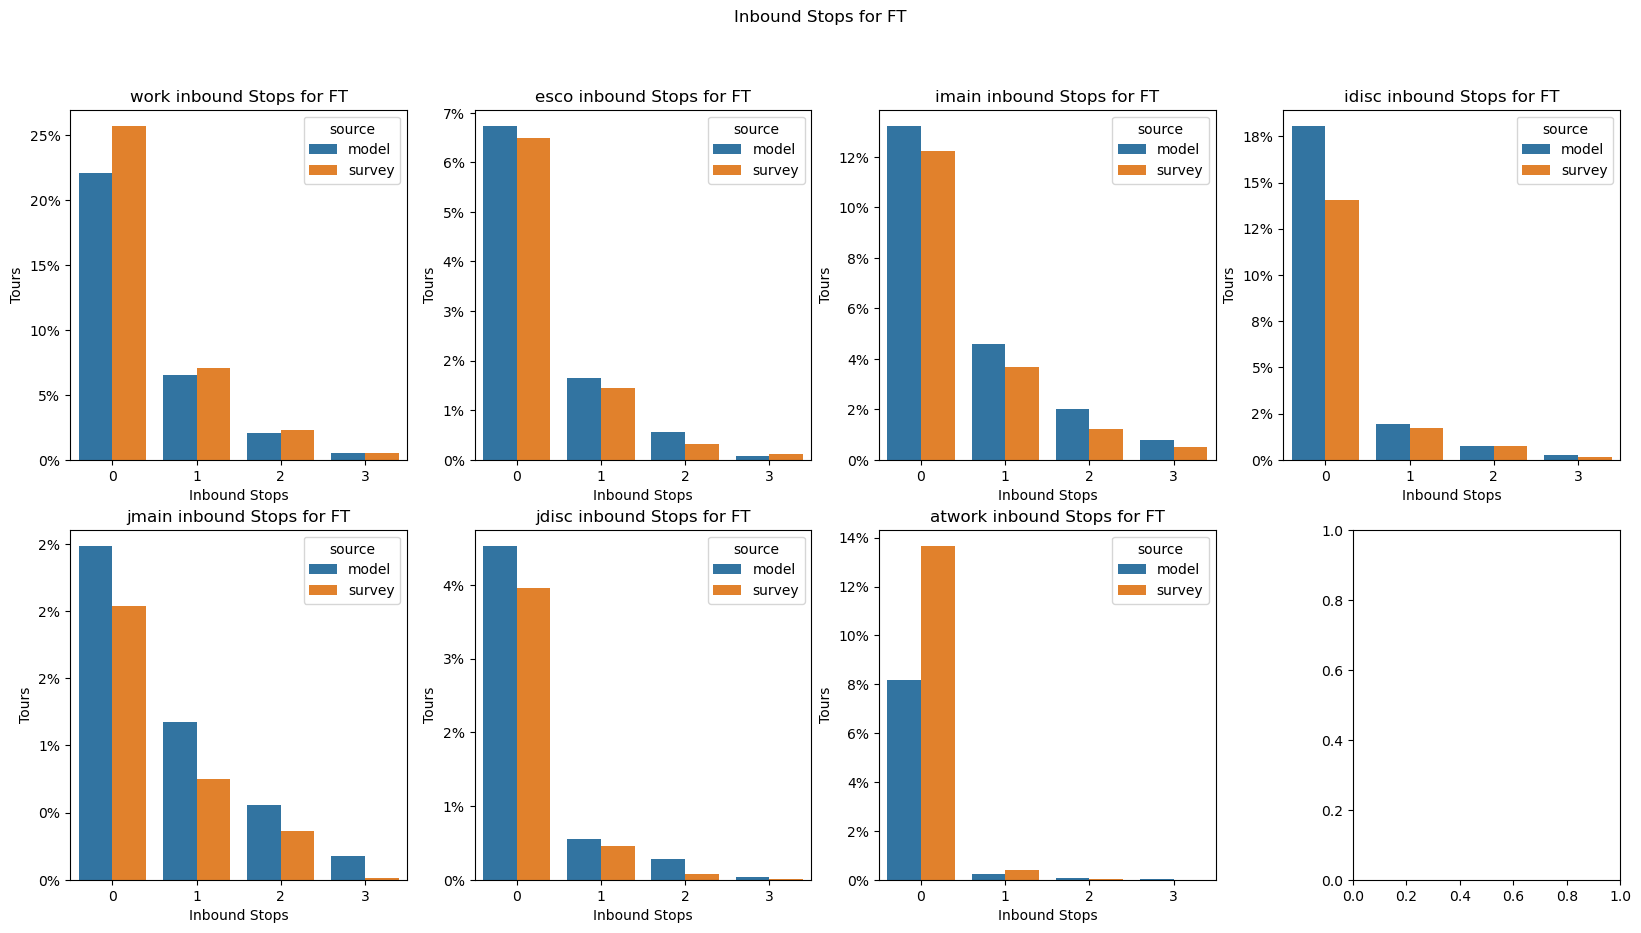

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is

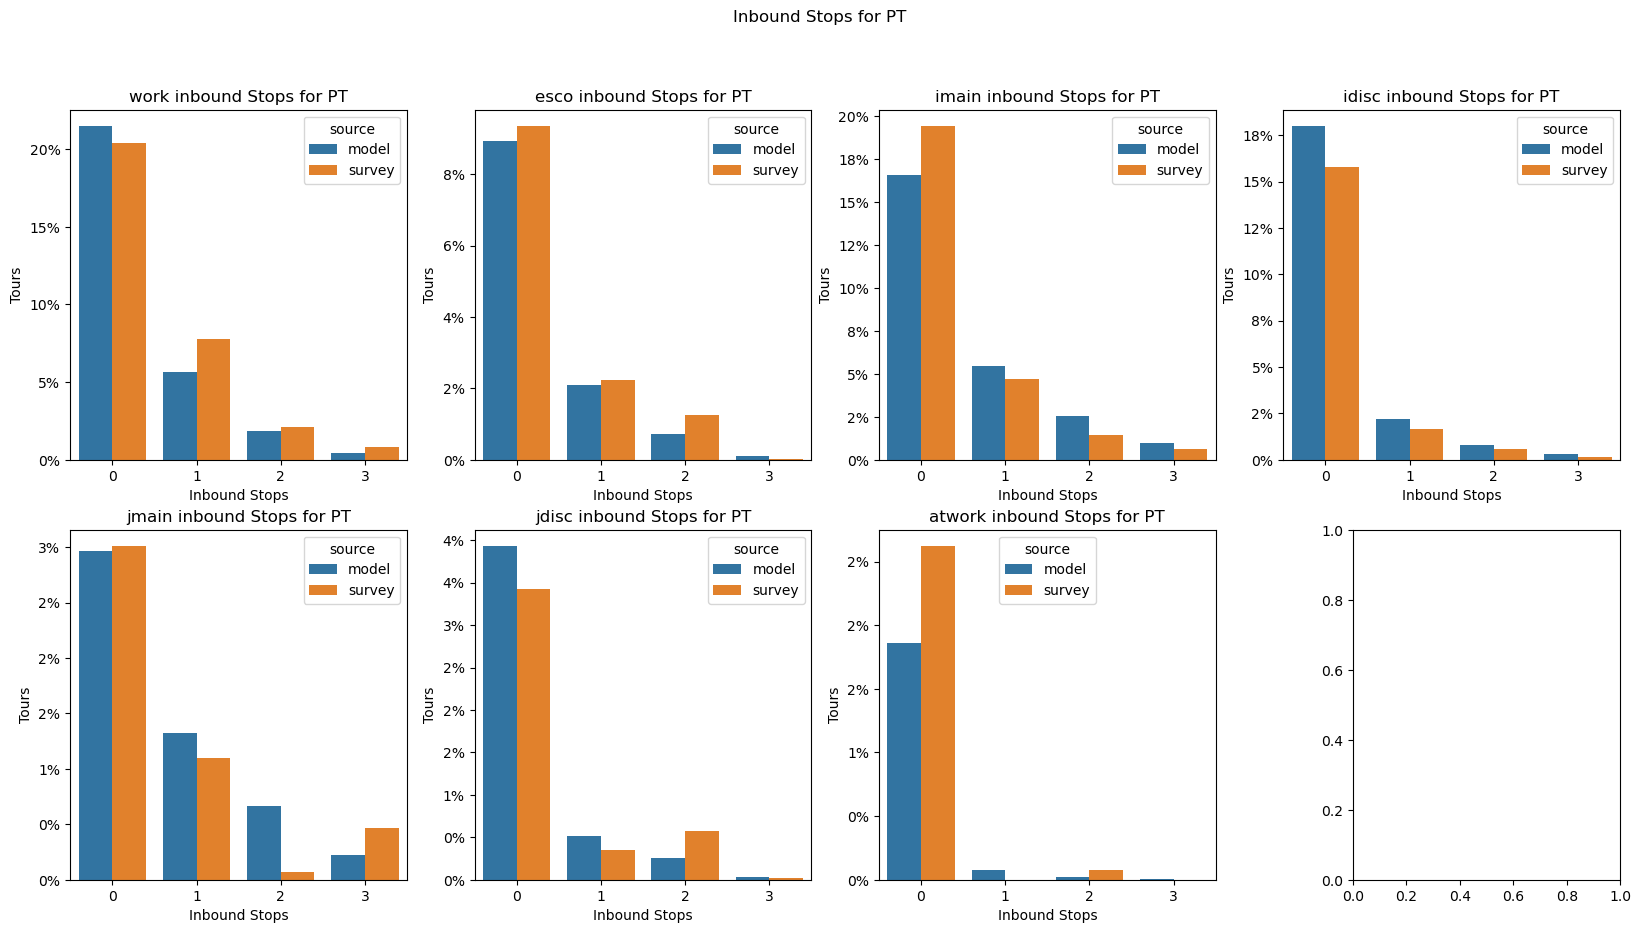

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is

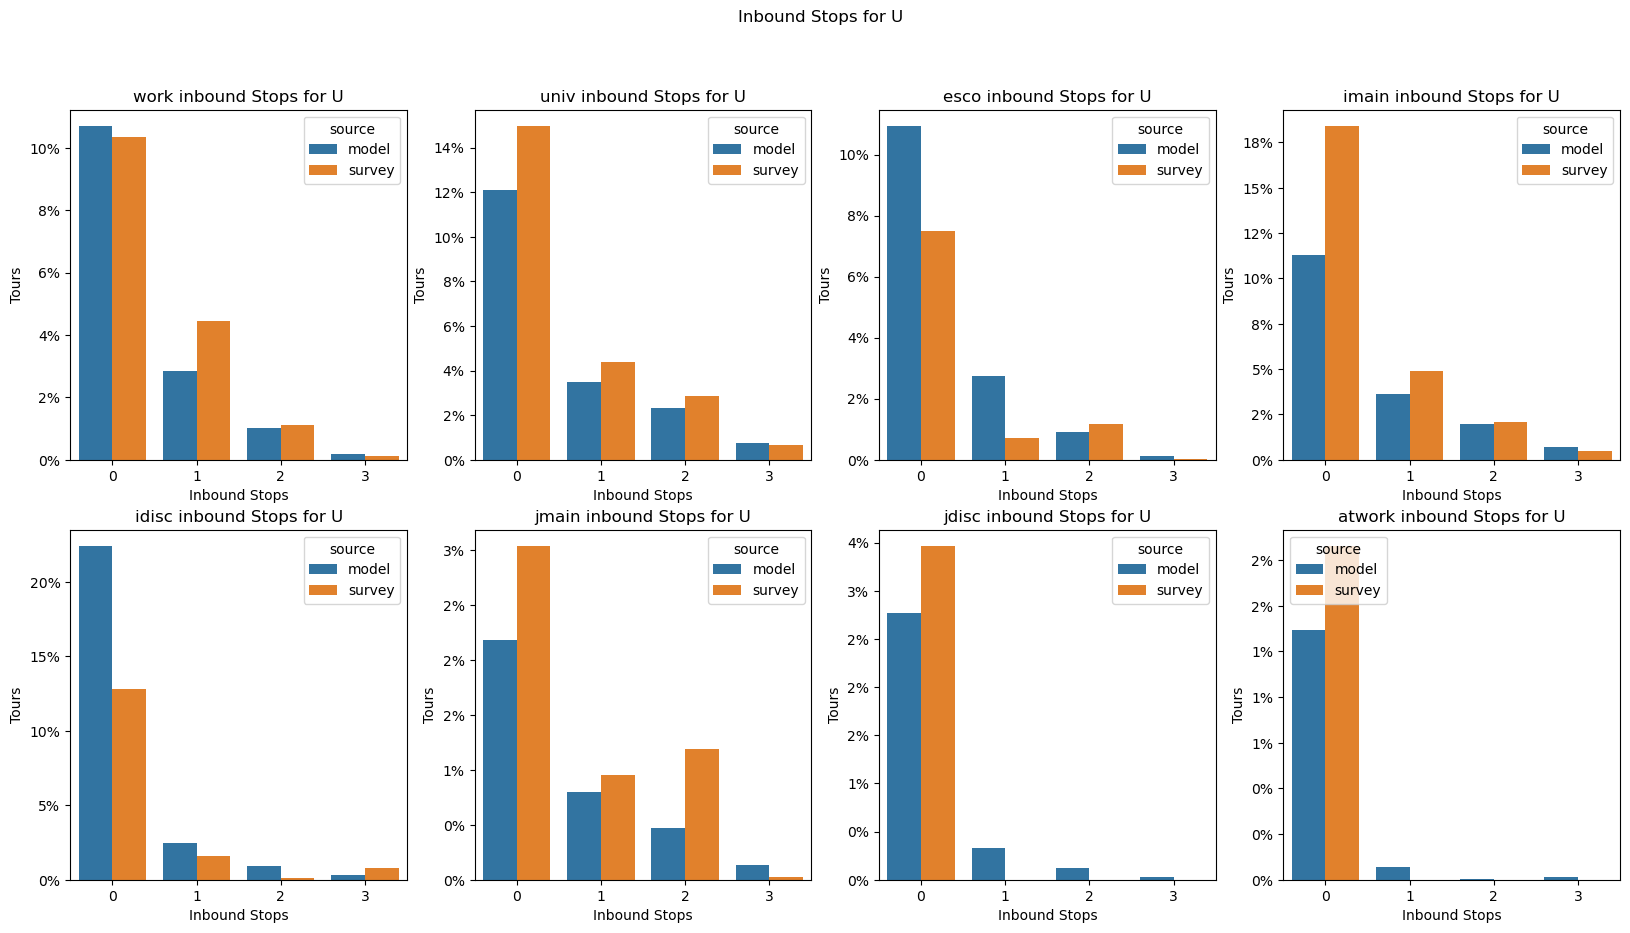

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is

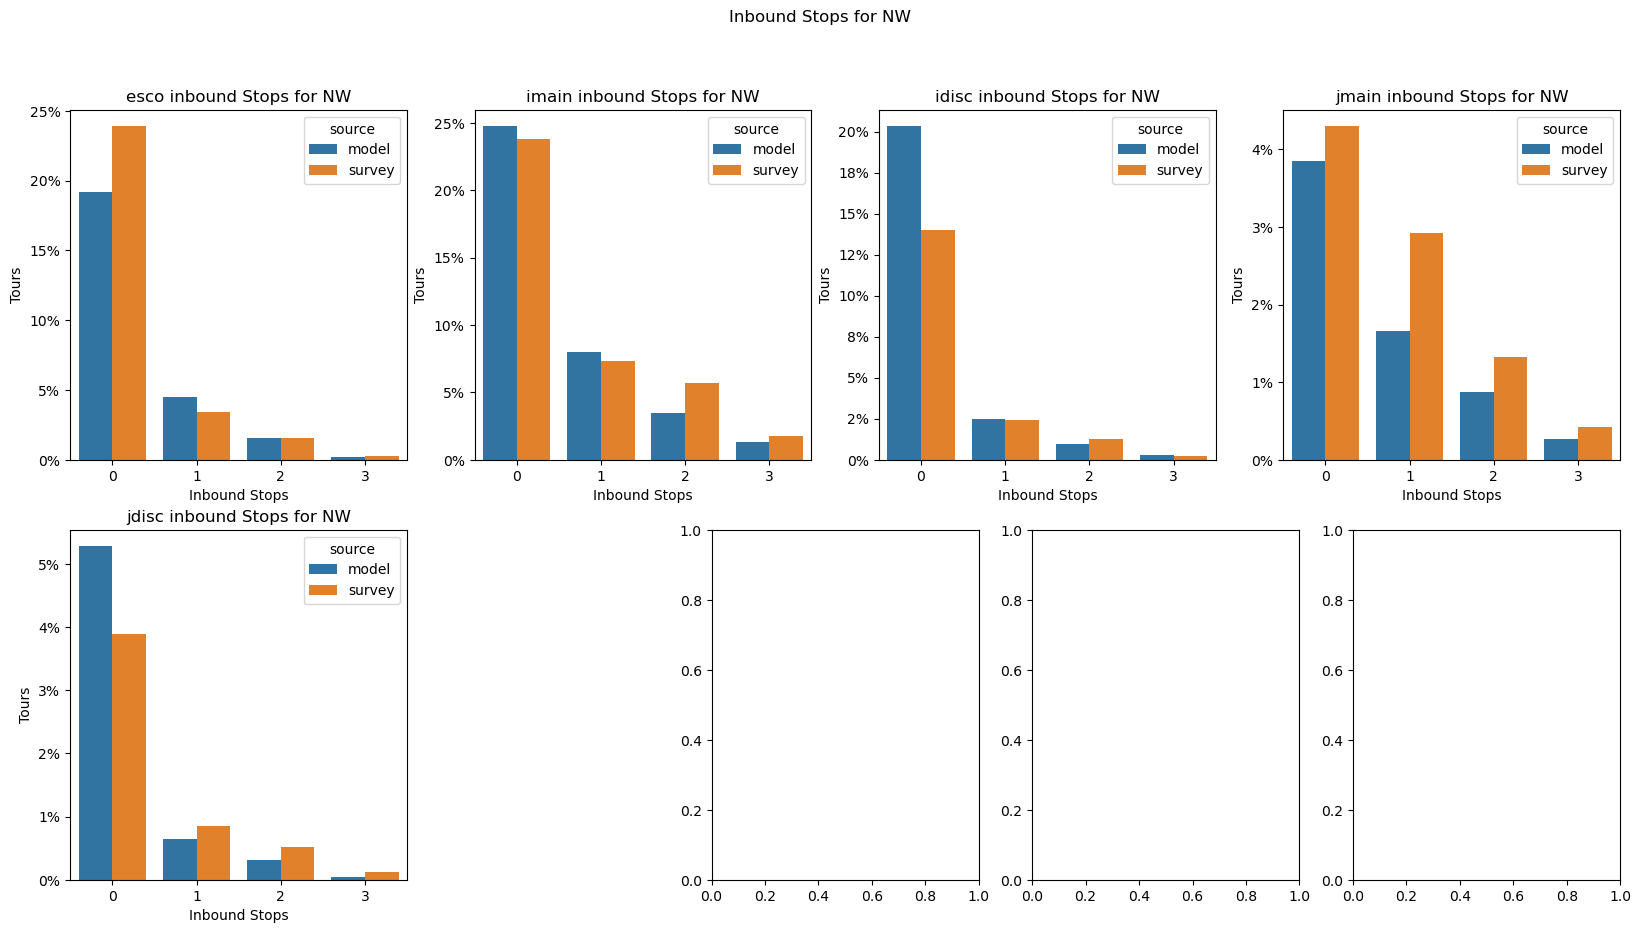

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is

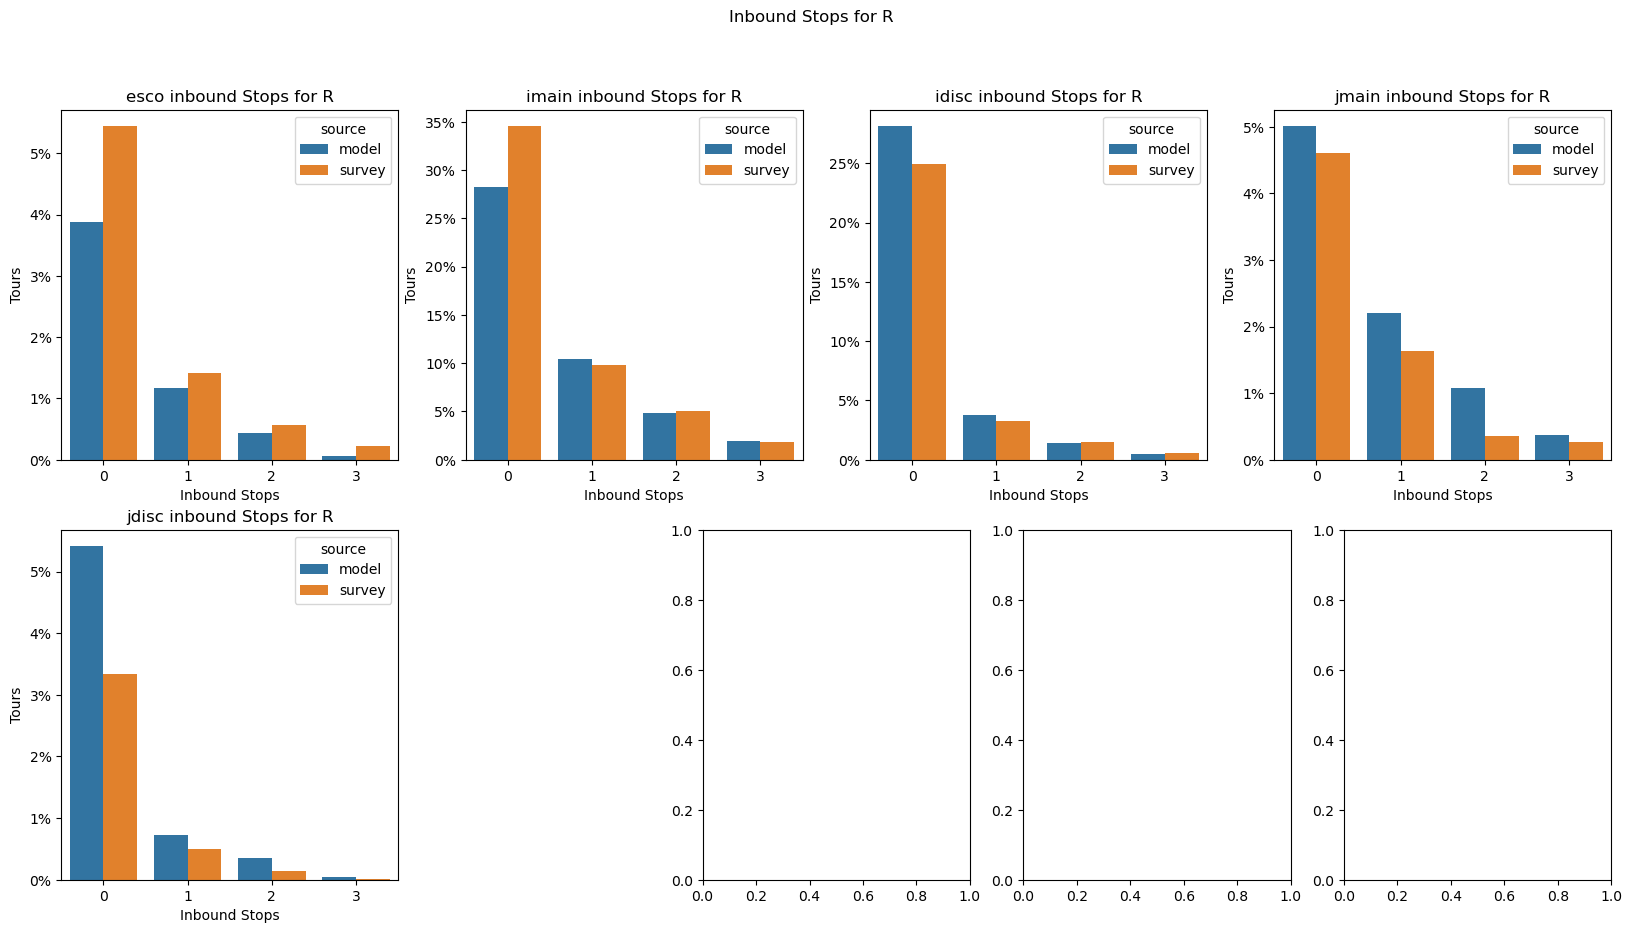

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is

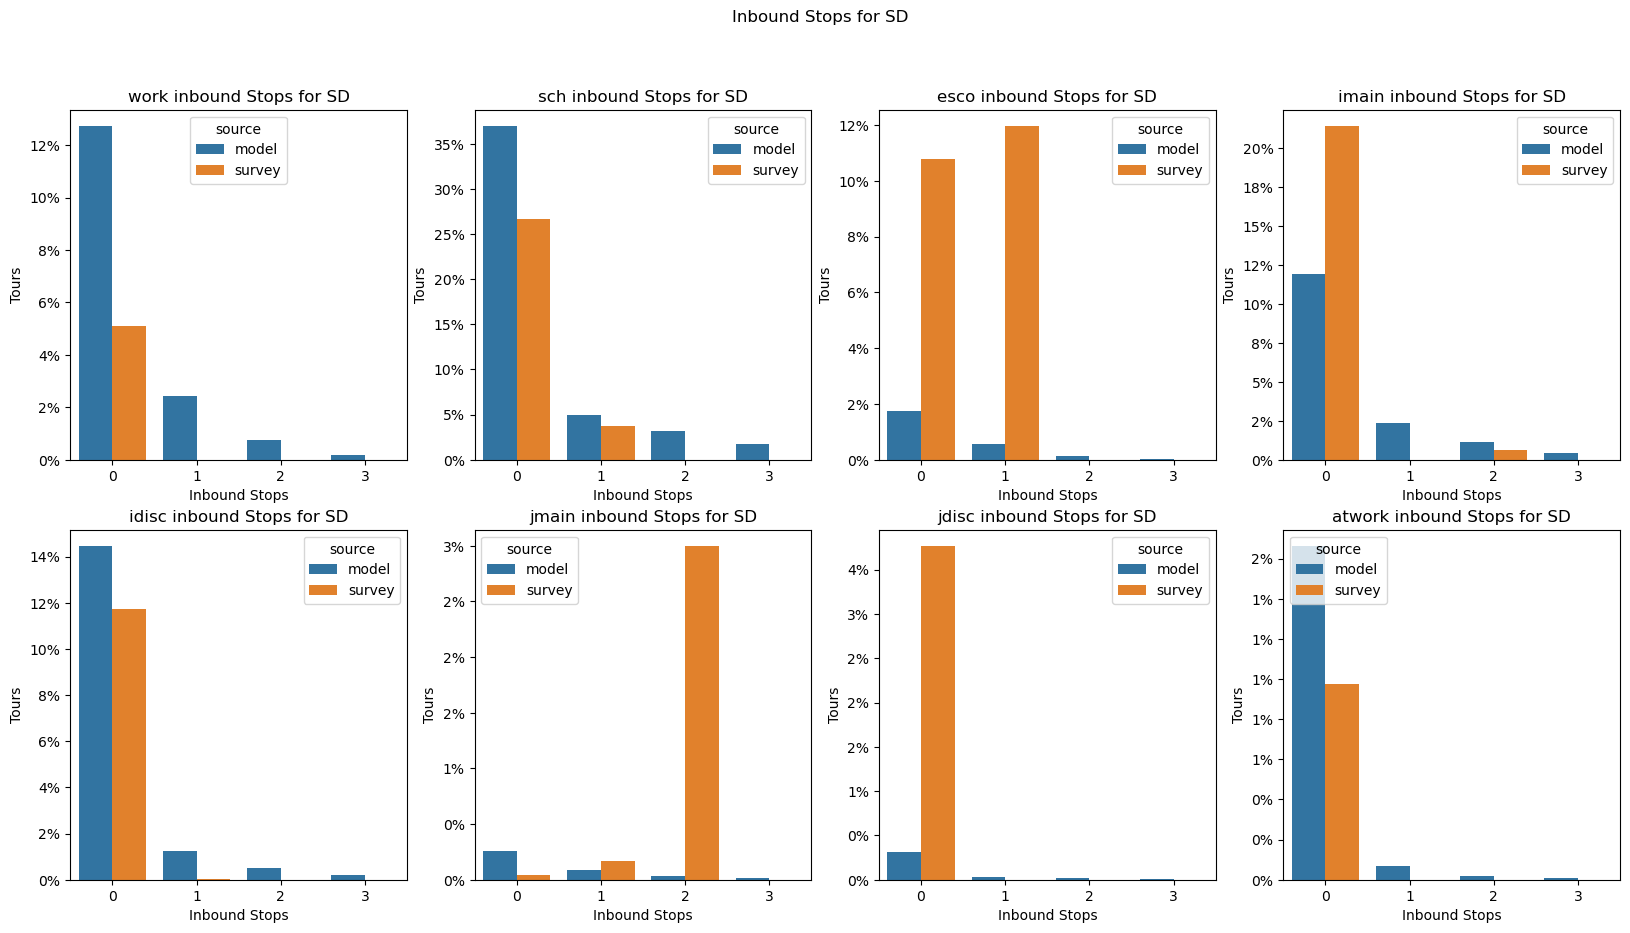

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is

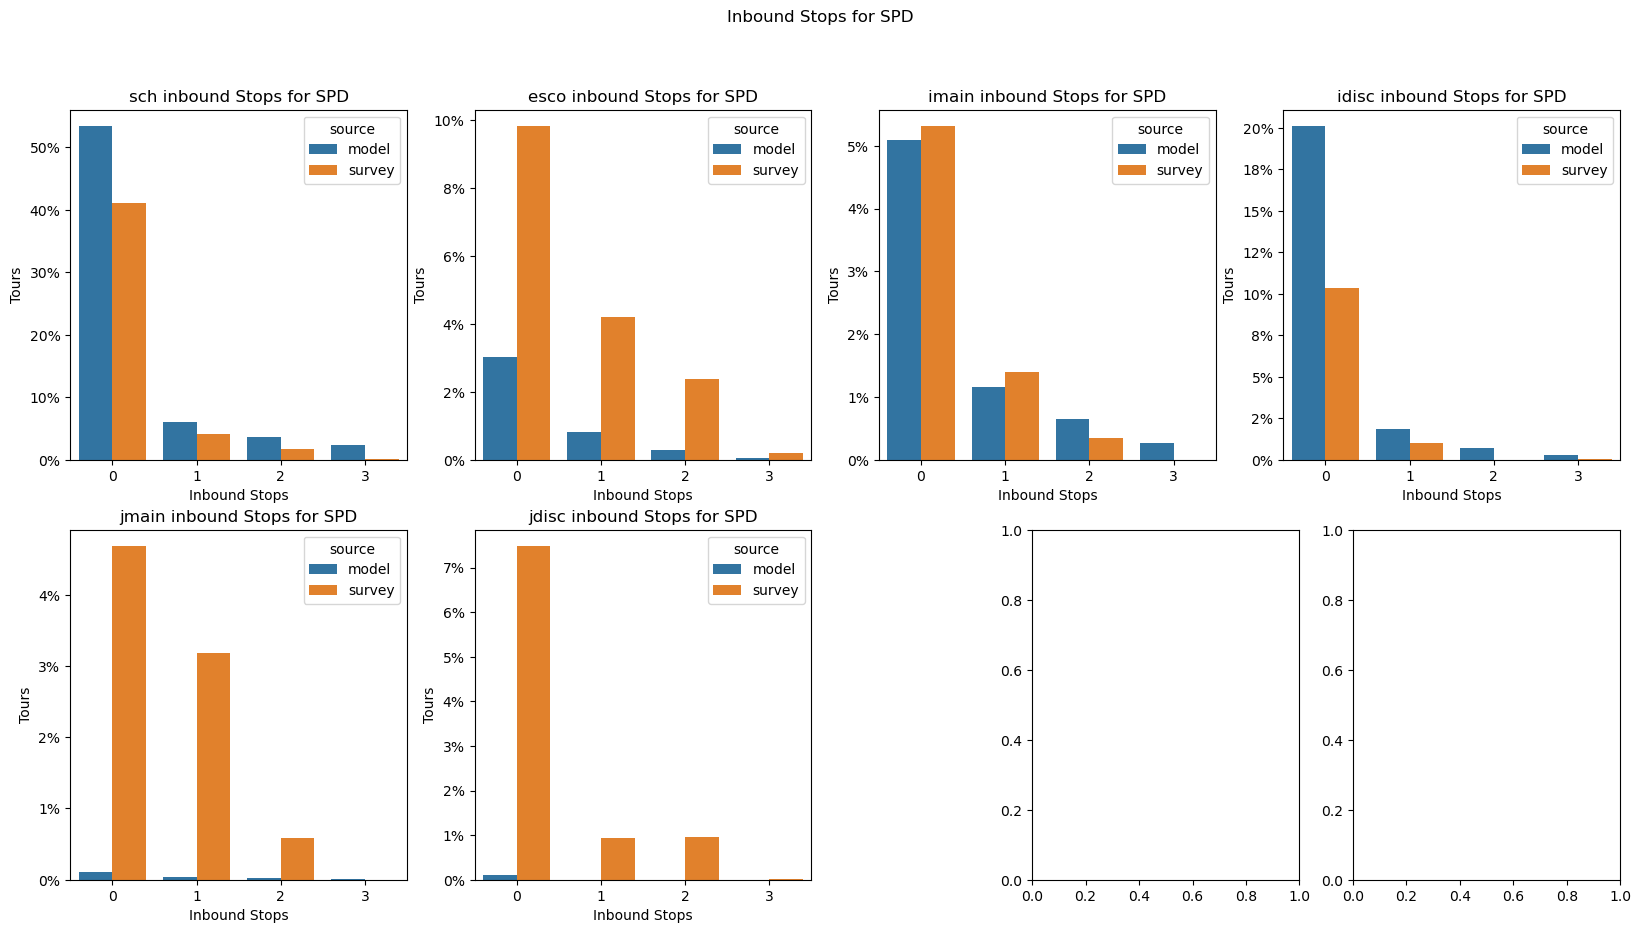

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(plot_idx + count)
C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_12484\1896494287.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is

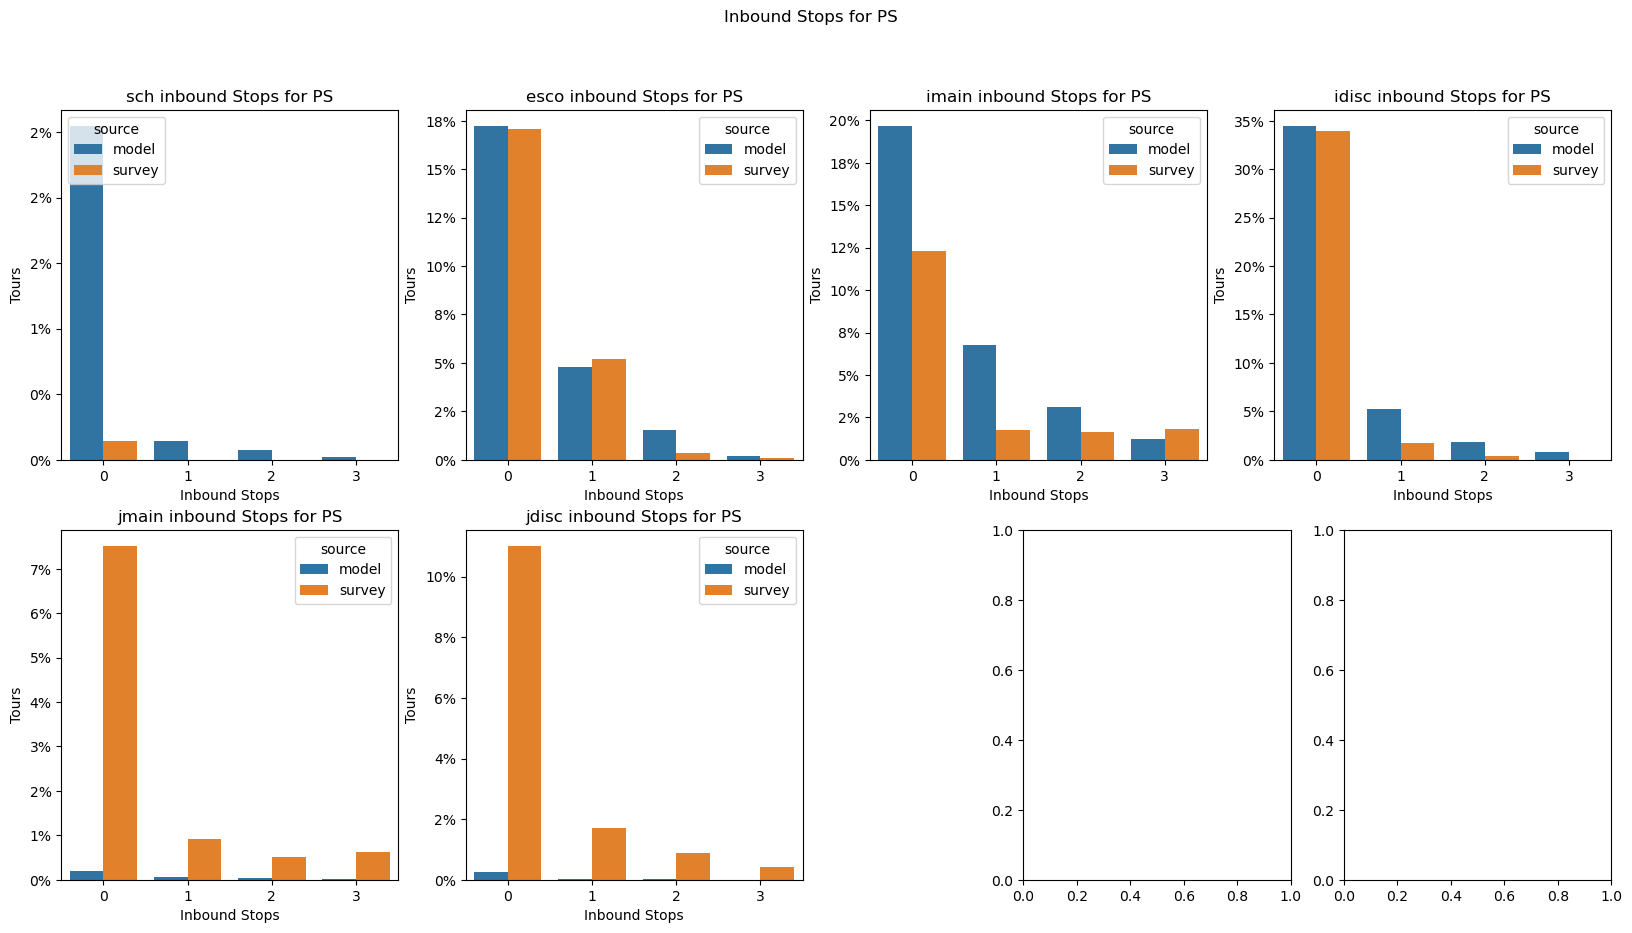

In [419]:
for pt_key, pt_val in PERTYPEMAP.items():
    plot_data1 = ib_compare.xs(pt_key, level = 0).reset_index()
    plot_data1['model'] = plot_data1['model'] / plot_data1['model'].sum()
    plot_data1['survey'] = plot_data1['survey'] / plot_data1['survey'].sum()
    plot_data1 = plot_data1.melt(id_vars = ['ib_stops', 'purp_coded'], var_name = 'source', value_name = 'tours')
    fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize=(20, 10))
    plot_idx = 240
    count = 1
    for purp in TOUR_TYPES:
        plot_data = plot_data1[plot_data1['purp_coded'] == purp]
        if plot_data.shape[0] > 0:
            ax = plt.subplot(plot_idx + count)
            sns.barplot(data = plot_data, x = 'ib_stops', y = 'tours', hue = 'source')
            plt.title(f"{purp} inbound Stops for {pt_val}")
            plt.ylabel('Tours')
            plt.xlabel('Inbound Stops')
            ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0%}'))
            count += 1
            
    plt.suptitle(f"Inbound Stops for {pt_val}")
    plt.show()

## For Calibration 2

In [397]:
calib_tables = {}

for purp in TOUR_TYPES:
    calib_tables[purp] = comb_purp.xs(purp, level = 0).reset_index()
    calib_tables[purp]['model_percent'] = calib_tables[purp]['model'] / calib_tables[purp]['model'].sum()
    calib_tables[purp]['survey_percent'] = calib_tables[purp]['survey'] / calib_tables[purp]['survey'].sum()
    calib_tables[purp]['adjustment'] = np.log(calib_tables[purp]['survey_percent'] / calib_tables[purp]['model_percent'])
    if purp in ['jmain', 'jdisc']:
        calib_tables[purp]['coefficient_name'] = calib_tables[purp].apply(lambda x: f"asc_joint_{x['ob_stops'].astype(int)}out_{x['ib_stops'].astype(int)}in", axis = 1)
    else:
        calib_tables[purp]['coefficient_name'] = calib_tables[purp].apply(lambda x: f"asc_{x['ob_stops'].astype(int)}out_{x['ib_stops'].astype(int)}in", axis = 1)
    calib_tables[purp].set_index('coefficient_name', inplace = True)
    calib_tables[purp].loc['asc_0out_0in', 'adjustment'] = 0.0

# Maint and Disc are together, joint will have additional constants if necessary
calib_tables['main'] = calib_tables['imain'].copy()
calib_tables['main']['model'] = calib_tables['imain']['model'].fillna(0) + calib_tables['jmain']['model'].fillna(0)
calib_tables['main']['survey'] = calib_tables['imain']['survey'].fillna(0) + calib_tables['jmain']['survey'].fillna(0)
calib_tables['main']['model_percent'] = calib_tables['main']['model'] / calib_tables['main']['model'].sum()
calib_tables['main']['survey_percent'] = calib_tables['main']['survey'] / calib_tables['main']['survey'].sum()

calib_tables['disc'] = calib_tables['idisc'].copy()
calib_tables['disc']['model'] = calib_tables['idisc']['model'].fillna(0) + calib_tables['jdisc']['model'].fillna(0)
calib_tables['disc']['survey'] = calib_tables['idisc']['survey'].fillna(0) + calib_tables['jdisc']['survey'].fillna(0)
calib_tables['disc']['model_percent'] = calib_tables['disc']['model'] / calib_tables['disc']['model'].sum()
calib_tables['disc']['survey_percent'] = calib_tables['disc']['survey'] / calib_tables['disc']['survey'].sum()


c:\Users\andrew.rohne\.conda\envs\asim_asr_dev\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\andrew.rohne\.conda\envs\asim_asr_dev\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\andrew.rohne\.conda\envs\asim_asr_dev\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [409]:
def update_coefs(filename, adjust_df):
    coefs = pd.read_csv(filename).set_index('coefficient_name')
    coefs['adjust'] = adjust_df['adjustment'].reindex(coefs.index).fillna(0.0)
    coefs['old_value'] = coefs['value']
    coefs['value'] = np.minimum(15, np.maximum(-15, coefs['value'] + coefs['adjust'] * DAMPING_FACTOR))
    coefs[['Description', 'value']].to_csv(filename, index = True)
    
combined_tour_purps = ['work', 'univ', 'sch', 'esco', 'main', 'disc', 'atwork'] 

file_to_purp = {'work': 'work', 'univ': 'univ', 'sch': 'school', 'esco': 'escort', 'main': ['shopping', 'othmaint'], 
    'disc': ['eatout', 'social', 'othdiscr'], 'atwork': 'atwork'  
}

has_joint = {'work': False, 'univ': False, 'sch': False, 'esco': True, 'main': True, 'disc': True, 'atwork': False} #TODO: check atwork

if UPDATE_COEFFICIENTS:
    for tour_purp in combined_tour_purps:
        print(f"Tour Purpose: {tour_purp}")
        if not has_joint[tour_purp]:
            if type(file_to_purp[tour_purp]) == str:
                update_coefs(os.path.join(ASIM_CONFIGS_PATH, f"stop_frequency_coefficients_{file_to_purp[tour_purp]}.csv"), calib_tables[tour_purp])
            elif type(file_to_purp[tour_purp]) == list:
                print('multiple files')
                for fp in file_to_purp[tour_purp]:
                    print(f"Opening stop_frequency_coefficients_{fp}.csv")
        else:
            if type(file_to_purp[tour_purp]) == str:
                update_coefs(os.path.join(ASIM_CONFIGS_PATH, f"stop_frequency_coefficients_{file_to_purp[tour_purp]}.csv"), calib_tables[tour_purp])
            elif type(file_to_purp[tour_purp]) == list:
                print('multiple files + joint')
                for fp in file_to_purp[tour_purp]:
                    update_coefs(os.path.join(ASIM_CONFIGS_PATH, f"stop_frequency_coefficients_{fp}.csv"), calib_tables[f"i{tour_purp}"])
                    update_coefs(os.path.join(ASIM_CONFIGS_PATH, f"stop_frequency_coefficients_{fp}.csv"), calib_tables[f"j{tour_purp}"])
                    



Tour Purpose: work
Tour Purpose: univ
Tour Purpose: sch
Tour Purpose: esco
Tour Purpose: main
multiple files + joint
Tour Purpose: disc
multiple files + joint
Tour Purpose: atwork
